In [78]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import PartialDependenceDisplay

from imblearn.over_sampling import RandomOverSampler, SMOTENC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from keras_tuner import RandomSearch
import xgboost as xgb
from xgboost import XGBClassifier, Booster
from catboost import CatBoostClassifier, Pool
from pyswarm import pso
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

import shap
import lime
import lime.lime_tabular
from IPython.display import HTML, display


### 1.1 Preprocessing

In [79]:
df=pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
df.columns = df.columns.str.lower()
df.sample(5)


gender        age    height      weight family_history_with_overweight  \
1641    Male  29.620095  1.787933  112.536367                            yes   
399     Male  21.000000  1.650000   60.000000                             no   
1921  Female  25.918524  1.621231  104.986792                            yes   
880   Female  18.947102  1.518917   60.267427                             no   
858     Male  26.047077  1.745950   80.018571                            yes   

     favc      fcvc       ncp        caec smoke      ch2o  scc       faf  \
1641  yes  2.008245  3.000000   Sometimes    no  2.040137   no  0.000000   
399    no  3.000000  1.000000  Frequently    no  1.000000   no  0.000000   
1921  yes  3.000000  3.000000   Sometimes    no  1.653049   no  0.139159   
880   yes  2.838037  2.737571   Sometimes    no  1.144467  yes  0.753782   
858   yes  1.993101  3.171082   Sometimes    no  2.364498   no  1.224743   

           tue       calc                 mtrans          nobeyesdad  
1641  0.474216  Sometimes             Automobile     Obesity_Type_II  
399   0.000000  Sometimes              Motorbike       Normal_Weight  
1921  0.711331  Sometimes  Public_Transportation    Obesity_Type_III  
880   1.286844  Sometimes  Public_Transportation  Overweight_Level_I  
858   0.022245  Sometimes  Public_Transportation  Overweight_Level_I

In [80]:
df.rename(columns={
    'calc': 'alc_intake',
    'favc': 'freq_consum_of_high_cal_food',
    'fcvc': 'Freq_of_veg_consum',
    'ncp': 'Num_of_main_meals',
    'scc': 'Consum_of_sweet_drinks',
    'ch2o': 'water_intake',
    'faf': 'Phys_activity_freq',
    'tue': 'Time_using_technology_devices',
    'caec': 'Consum_of_food_between_meals',
    'mtrans': 'Transport_Mode',
    'nobeyesdad': 'Obesity_level'
}, inplace=True)

df.columns = df.columns.str.lower()

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          2111 non-null   object 
 1   age                             2111 non-null   float64
 2   height                          2111 non-null   float64
 3   weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   freq_consum_of_high_cal_food    2111 non-null   object 
 6   freq_of_veg_consum              2111 non-null   float64
 7   num_of_main_meals               2111 non-null   float64
 8   consum_of_food_between_meals    2111 non-null   object 
 9   smoke                           2111 non-null   object 
 10  water_intake                    2111 non-null   float64
 11  consum_of_sweet_drinks          2111 non-null   object 
 12  phys_activity_freq              21

In [82]:
# --- Check for duplicate rows ---
duplicate_count = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")
df = df.drop_duplicates()
print("Duplicates removed. New shape:", df.shape)



Number of duplicate rows: 24
Duplicates removed. New shape: (2087, 17)


In [83]:
# Renaming obesity levels
df['obesity_level'] = df['obesity_level'].replace("Insufficient_Weight", "Under_Weight")
df.loc[df['obesity_level'].isin(['Overweight_Level_I', 'Overweight_Level_II']), 'obesity_level'] = 'Over_weight'
print(df['obesity_level'].value_counts())


obesity_level
Over_weight         566
Obesity_Type_I      351
Obesity_Type_III    324
Obesity_Type_II     297
Normal_Weight       282
Under_Weight        267
Name: count, dtype: int64


In [84]:
# Distribution of features
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    fig = px.histogram(
        df,
        y=col,
        color=col,
        title=f"Distribution of {col}",
        category_orders={col: df[col].value_counts().index.tolist()}
    )
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        bargap=0.2
    )
    fig.show()


In [85]:
numerical_cols = df.select_dtypes(exclude=['object']).columns
corr_matrix = df[numerical_cols].corr()

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu',
    title="Correlation Heatmap",
    labels=dict(color="Correlation"),
    template="plotly_white"
)

fig.update_layout(
    width=800,
    height=700
)

fig.show()


In [86]:
# Categorical features vs target
for col in categorical_cols:
    if col != 'obesity_level':
        fig = px.histogram(df, x=col, color='obesity_level',
                           barmode='group',
                           title=f"{col} vs obesity_level",
                           labels={col: col, 'obesity_level': 'Obesity Class'})
        fig.show()


In [87]:
# Balancing the dataset using SMOTENC
cat_cols = ['family_history_with_overweight', 'gender', 'transport_mode',
            'freq_consum_of_high_cal_food', 'consum_of_sweet_drinks', 
            'smoke', 'consum_of_food_between_meals', 'alc_intake']

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le 
y_le = LabelEncoder()
y = y_le.fit_transform(df['obesity_level'])


X = df.drop('obesity_level', axis=1)

cat_feature_indices = [X.columns.get_loc(col) for col in cat_cols]

smote_nc = SMOTENC(categorical_features=cat_feature_indices, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

print("Before SMOTE:", pd.Series(y).value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())



Before SMOTE: 4    566
1    351
3    324
2    297
0    282
5    267
Name: count, dtype: int64
After SMOTE: 0    566
4    566
1    566
5    566
2    566
3    566
Name: count, dtype: int64


In [88]:
# Decoding the resampled data
ds= pd.DataFrame(X_resampled, columns=X.columns)

for col, le in le_dict.items():
    ds[col] = le.inverse_transform(ds[col].astype(int))

y_decoded = y_le.inverse_transform(y_resampled.astype(int))

ds['obesity_level'] = y_decoded
ds.head()

gender   age  height  weight family_history_with_overweight  \
0  Female  21.0    1.62    64.0                            yes   
1  Female  21.0    1.52    56.0                            yes   
2    Male  23.0    1.80    77.0                            yes   
3    Male  27.0    1.80    87.0                             no   
4    Male  22.0    1.78    89.8                             no   

  freq_consum_of_high_cal_food  freq_of_veg_consum  num_of_main_meals  \
0                           no                 2.0                3.0   
1                           no                 3.0                3.0   
2                           no                 2.0                3.0   
3                           no                 3.0                3.0   
4                           no                 2.0                1.0   

  consum_of_food_between_meals smoke  water_intake consum_of_sweet_drinks  \
0                    Sometimes    no           2.0                     no   
1                    Sometimes   yes           3.0                    yes   
2                    Sometimes    no           2.0                     no   
3                    Sometimes    no           2.0                     no   
4                    Sometimes    no           2.0                     no   

   phys_activity_freq  time_using_technology_devices  alc_intake  \
0                 0.0                            1.0          no   
1                 3.0                            0.0   Sometimes   
2                 2.0                            1.0  Frequently   
3                 2.0                            0.0  Frequently   
4                 0.0                            0.0   Sometimes   

          transport_mode  obesity_level  
0  Public_Transportation  Normal_Weight  
1  Public_Transportation  Normal_Weight  
2  Public_Transportation  Normal_Weight  
3                Walking    Over_weight  
4  Public_Transportation    Over_weight

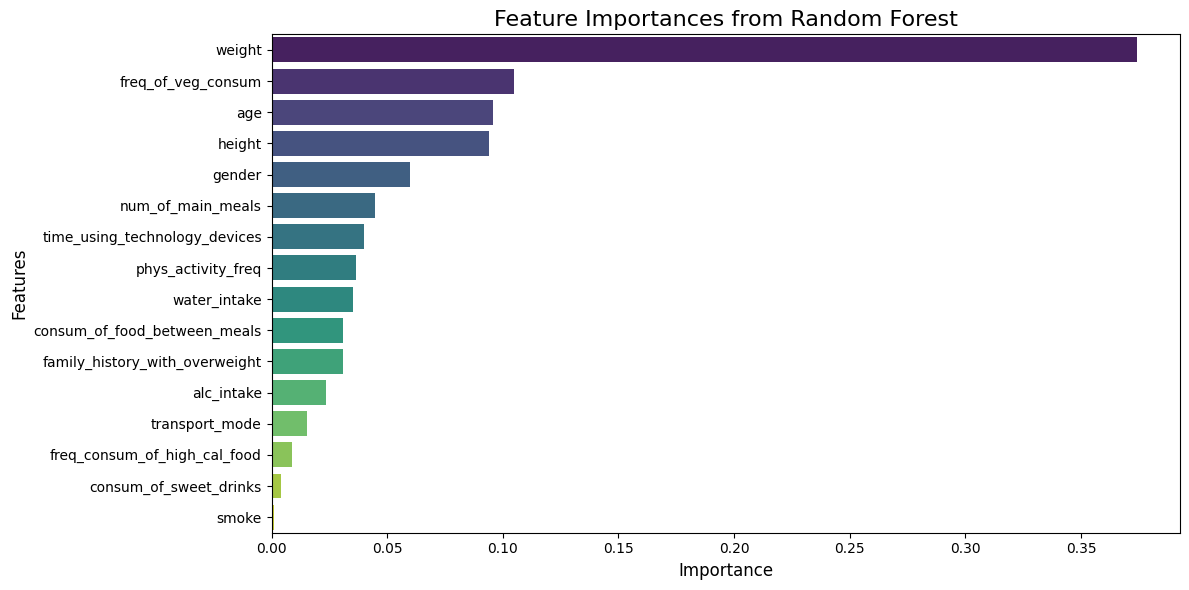

In [89]:
#Feature Importance using Random Forest
X = ds.drop('obesity_level', axis=1)
y = ds['obesity_level']

categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

y = LabelEncoder().fit_transform(y)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(12,6))

sns.barplot(x=importances.values, y=importances.index, palette="viridis")

plt.title("Feature Importances from Random Forest", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()



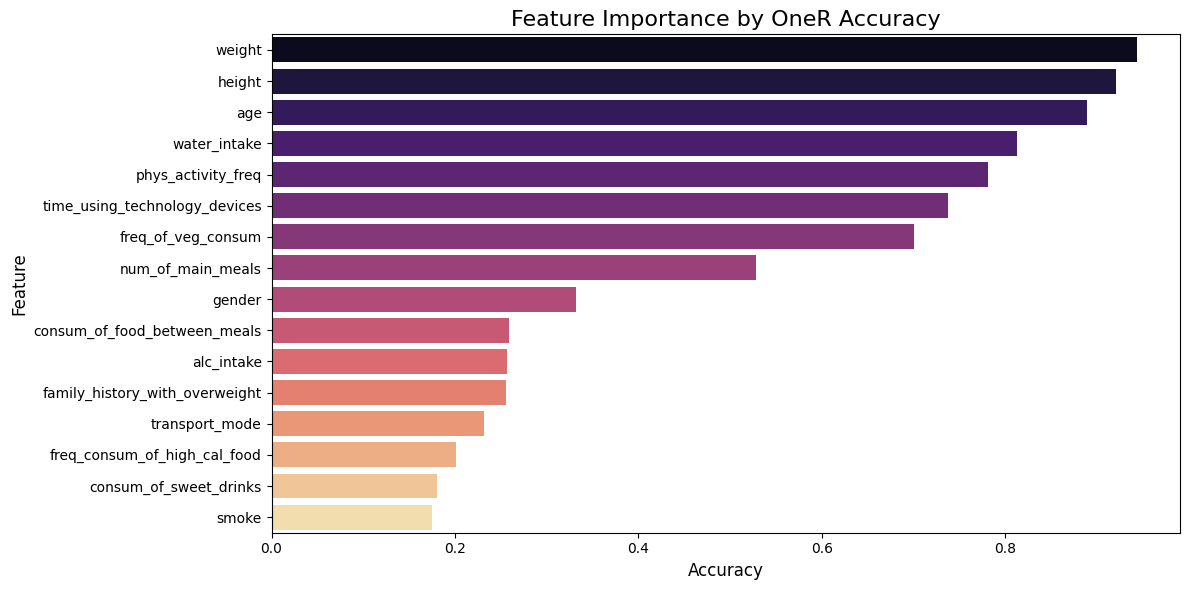

Best feature according to OneR: weight with accuracy: 0.943168433451119


In [90]:

# OneR feature evaluation
oneR_results = {}

for feature in X.columns:
   
    rules = X.groupby(feature).apply(lambda x: pd.Series(y[x.index]).value_counts().idxmax())
    
    y_pred = X[feature].map(rules)

    acc = accuracy_score(y, y_pred)
    oneR_results[feature] = acc

oneR_results = pd.Series(oneR_results).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=oneR_results.values, y=oneR_results.index, palette="magma")
plt.title("Feature Importance by OneR Accuracy", fontsize=16)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

print("Best feature according to OneR:", oneR_results.idxmax(), "with accuracy:", oneR_results.max())


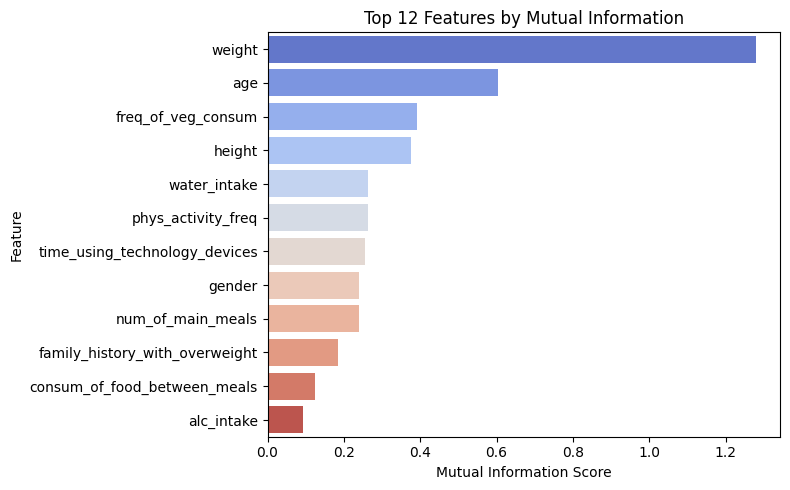

In [91]:
#best features using Mutual Information
mi = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

top_n = 12
top_features_mi = mi_series.head(top_n).index.tolist()

plt.figure(figsize=(8,5))
sns.barplot(x=mi_series[top_features_mi].values, y=top_features_mi, palette="coolwarm")
plt.title(f"Top {top_n} Features by Mutual Information")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [92]:
#dropping less important features
cols_to_drop = ["transport_mode", 
                "freq_consum_of_high_cal_food", 
                "consum_of_sweet_drinks", 
                "smoke"]

df = ds.drop(columns=cols_to_drop, errors="ignore")

### 2. Modelling

In [93]:
# Columns to one-hot encode
one_hot_cols = ['family_history_with_overweight','gender','obesity_level']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df[one_hot_cols])
feature_names = encoder.get_feature_names_out(one_hot_cols)
df_encoded = pd.DataFrame(encoded_data, columns=feature_names, index=df.index)
df = pd.concat([df.drop(columns=one_hot_cols), df_encoded], axis=1)

# Ordinal encoder
categories_list = [['no', 'Sometimes', 'Frequently', 'Always']] * 2
encoder = OrdinalEncoder(categories=categories_list)
columns_to_encode = ['consum_of_food_between_meals', 'alc_intake']
df[columns_to_encode] = encoder.fit_transform(df[columns_to_encode])
df.head()


age  height  weight  freq_of_veg_consum  num_of_main_meals  \
0  21.0    1.62    64.0                 2.0                3.0   
1  21.0    1.52    56.0                 3.0                3.0   
2  23.0    1.80    77.0                 2.0                3.0   
3  27.0    1.80    87.0                 3.0                3.0   
4  22.0    1.78    89.8                 2.0                1.0   

   consum_of_food_between_meals  water_intake  phys_activity_freq  \
0                           1.0           2.0                 0.0   
1                           1.0           3.0                 3.0   
2                           1.0           2.0                 2.0   
3                           1.0           2.0                 2.0   
4                           1.0           2.0                 0.0   

   time_using_technology_devices  alc_intake  \
0                            1.0         0.0   
1                            0.0         1.0   
2                            1.0         2.0   
3                            0.0         2.0   
4                            0.0         1.0   

   family_history_with_overweight_no  family_history_with_overweight_yes  \
0                                0.0                                 1.0   
1                                0.0                                 1.0   
2                                0.0                                 1.0   
3                                1.0                                 0.0   
4                                1.0                                 0.0   

   gender_Female  gender_Male  obesity_level_Normal_Weight  \
0            1.0          0.0                          1.0   
1            1.0          0.0                          1.0   
2            0.0          1.0                          1.0   
3            0.0          1.0                          0.0   
4            0.0          1.0                          0.0   

   obesity_level_Obesity_Type_I  obesity_level_Obesity_Type_II  \
0                           0.0                            0.0   
1                           0.0                            0.0   
2                           0.0                            0.0   
3                           0.0                            0.0   
4                           0.0                            0.0   

   obesity_level_Obesity_Type_III  obesity_level_Over_weight  \
0                             0.0                        0.0   
1                             0.0                        0.0   
2                             0.0                        0.0   
3                             0.0                        1.0   
4                             0.0                        1.0   

   obesity_level_Under_Weight  
0                         0.0  
1                         0.0  
2                         0.0  
3                         0.0  
4                         0.0

In [94]:

# Features (exclude one-hot targets)
X = df.drop(columns=[
    'obesity_level_Normal_Weight',
    'obesity_level_Obesity_Type_I',
    'obesity_level_Obesity_Type_II',
    'obesity_level_Obesity_Type_III',
    'obesity_level_Over_weight',
    'obesity_level_Under_Weight'
])

# Convert one-hot targets to single label
y_columns = [
    'obesity_level_Normal_Weight',
    'obesity_level_Obesity_Type_I',
    'obesity_level_Obesity_Type_II',
    'obesity_level_Obesity_Type_III',
    'obesity_level_Over_weight',
    'obesity_level_Under_Weight'
]

y = df[y_columns].idxmax(axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


# Train/Val/Test split
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


### 2.1 CatBoost

0:	learn: 0.7114009	test: 0.6640472	best: 0.6640472 (0)	total: 34.8ms	remaining: 34.7s
100:	learn: 0.9768616	test: 0.9607073	best: 0.9607073 (94)	total: 754ms	remaining: 6.71s
200:	learn: 0.9936895	test: 0.9685658	best: 0.9685658 (162)	total: 1.36s	remaining: 5.39s
300:	learn: 0.9991586	test: 0.9764244	best: 0.9764244 (285)	total: 2.01s	remaining: 4.68s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9764243615
bestIteration = 285

Shrink model to first 286 iterations.
Train Accuracy: 0.9987
Validation Accuracy: 0.9764
Test Accuracy: 0.9784
Accuracy difference (train - val): 0.0223
Diagnosis: Good fit


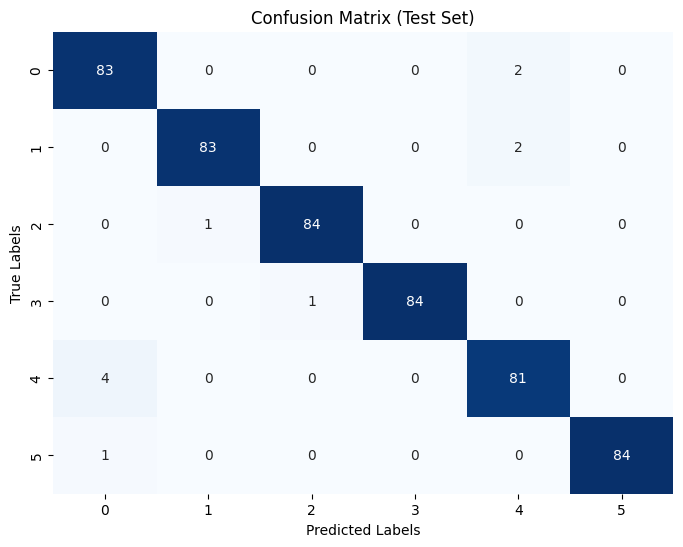

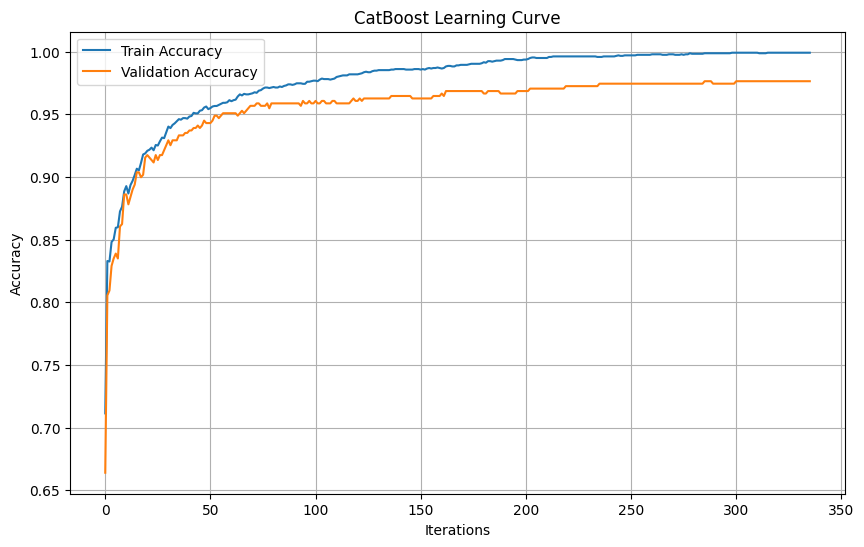

Accuracy : 0.9784
Precision: 0.9787
Recall   : 0.9784
F1 Score : 0.9785
=== Fairness Matrix by Gender ===

Gender: Male
Class | TPR     | FPR     | Precision
--------------------------------
    0 | 0.9756 | 0.0193 | 0.9091
    1 | 1.0000 | 0.0047 | 0.9722
    2 | 0.0000 | 0.0000 | 0.0000
    3 | 1.0000 | 0.0000 | 1.0000
    4 | 0.8974 | 0.0048 | 0.9722
    5 | 1.0000 | 0.0000 | 1.0000

Gender: Female
Class | TPR     | FPR     | Precision
--------------------------------
    0 | 0.9773 | 0.0046 | 0.9773
    1 | 0.9600 | 0.0000 | 1.0000
    2 | 1.0000 | 0.0056 | 0.9882
    3 | 0.0000 | 0.0000 | 0.0000
    4 | 1.0000 | 0.0139 | 0.9388
    5 | 0.9730 | 0.0000 | 1.0000

=== Gender Disparity Summary ===
Class 0: TPR diff = 0.0017, Precision diff = 0.0682
Class 1: TPR diff = 0.0400, Precision diff = 0.0278
Class 2: TPR diff = 1.0000, Precision diff = 0.9882
 Significant disparity detected in Class 2
Class 3: TPR diff = 1.0000, Precision diff = 1.0000
 Significant disparity detected in Class 

In [95]:

#building CatBoost model
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='Accuracy',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)


train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True)


#  Predictions
y_pred = cat_model.predict(X_test)
y_pred_probs = cat_model.predict_proba(X_test)

train_acc = cat_model.score(X_train, y_train)
val_acc = cat_model.score(X_val, y_val)
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting)"
elif diff > 0.1:
    diagnosis = "High variance (overfitting)"
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit"
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting"
else:
    diagnosis = "Validation > Training, unusual case"

#
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference (train - val): {diff:.4f}")
print(f"Diagnosis: {diagnosis}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


# Confusion Matrix and Sensitivity/Specificity
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 6. Learning Curve Plot

results = cat_model.get_evals_result()
plt.figure(figsize=(10,6))
plt.plot(results['learn']['Accuracy'], label='Train Accuracy')
plt.plot(results['validation']['Accuracy'], label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# 7. Fairness Metrics by Gender
def fairness_matrix_onehot_gender(y_true, y_pred_probs, X_test_df):
    """
    Computes TPR, FPR, Precision for gender_Female vs gender_Male
    """
    gender_onehot = X_test_df[['gender_Female', 'gender_Male']].values
    gender = np.argmax(gender_onehot, axis=1)  # 0=Male, 1=Female
    y_true_idx = y_true
    y_pred_idx = np.argmax(y_pred_probs, axis=1)
    
    groups = np.unique(gender)
    classes = np.unique(y_true_idx)
    results = {g: {} for g in groups}
    
    for g in groups:
        idx = np.where(gender==g)
        y_true_g = y_true_idx[idx]
        y_pred_g = y_pred_idx[idx]
        for c in classes:
            TP = np.sum((y_pred_g==c) & (y_true_g==c))
            FN = np.sum((y_pred_g!=c) & (y_true_g==c))
            FP = np.sum((y_pred_g==c) & (y_true_g!=c))
            TN = np.sum((y_pred_g!=c) & (y_true_g!=c))
            TPR = TP / (TP+FN) if (TP+FN) > 0 else 0
            FPR = FP / (FP+TN) if (FP+TN) > 0 else 0
            Precision = TP / (TP+FP) if (TP+FP) > 0 else 0
            results[g][c] = {'TPR': TPR, 'FPR': FPR, 'Precision': Precision}
    
    # Print
    print("=== Fairness Matrix by Gender ===")
    for g, class_metrics in results.items():
        gender_name = "Male" if g==0 else "Female"
        print(f"\nGender: {gender_name}")
        print("Class | TPR     | FPR     | Precision")
        print("-"*32)
        for c, metrics in class_metrics.items():
            print(f"{c:5d} | {metrics['TPR']:.4f} | {metrics['FPR']:.4f} | {metrics['Precision']:.4f}")
    
    return results

fairness_results = fairness_matrix_onehot_gender(y_test, y_pred_probs, X_test)

# 8. Gender Disparity Summary
print("\n=== Gender Disparity Summary ===")
num_classes = y_test.max() + 1
for c in range(num_classes):
    tpr_diff = abs(fairness_results[0][c]['TPR'] - fairness_results[1][c]['TPR'])
    precision_diff = abs(fairness_results[0][c]['Precision'] - fairness_results[1][c]['Precision'])
    print(f"Class {c}: TPR diff = {tpr_diff:.4f}, Precision diff = {precision_diff:.4f}")
    if tpr_diff > 0.1 or precision_diff > 0.1:
        print(f" Significant disparity detected in Class {c}")

# Sensitivity (Recall) & Specificity per class
num_classes = cm.shape[0]
sensitivity = []
specificity = []

for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivity.append(sens)
    specificity.append(spec)

for i in range(num_classes):
    print(f"Class {i}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")

# AUC Score (One-vs-Rest)

from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Compute macro-average AUC
auc = roc_auc_score(y_test_bin, y_pred_probs, average='macro', multi_class='ovr')
print(f"\nMacro-Average AUC: {auc:.4f}")




0:	learn: 0.7606226	test: 0.7524558	best: 0.7524558 (0)	total: 19.1ms	remaining: 57.2s
100:	learn: 0.9936895	test: 0.9685658	best: 0.9705305 (97)	total: 682ms	remaining: 19.6s
200:	learn: 0.9987379	test: 0.9783890	best: 0.9783890 (156)	total: 1.28s	remaining: 17.9s
300:	learn: 1.0000000	test: 0.9803536	best: 0.9803536 (218)	total: 1.96s	remaining: 17.6s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.9803536346
bestIteration = 218

Shrink model to first 219 iterations.
Train Accuracy: 0.9996
Validation Accuracy: 0.9804
Test Accuracy: 0.9824
Accuracy difference (train - val): 0.0192
Diagnosis: Good fit
Accuracy : 0.9824
Precision: 0.9825
Recall   : 0.9824
F1 Score : 0.9824


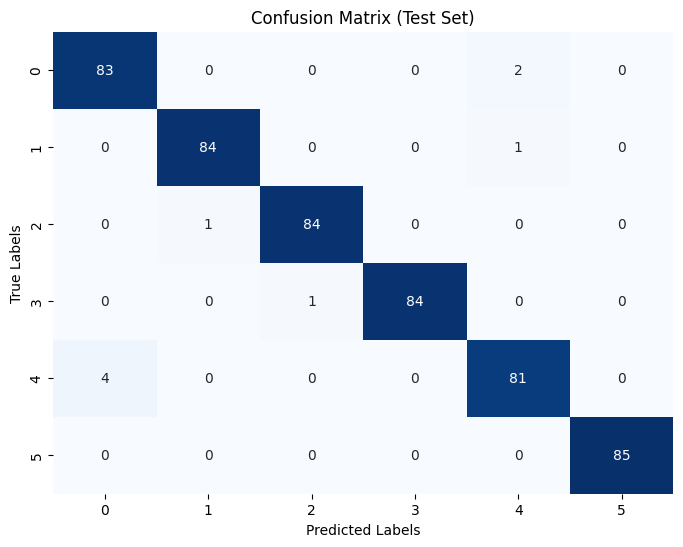

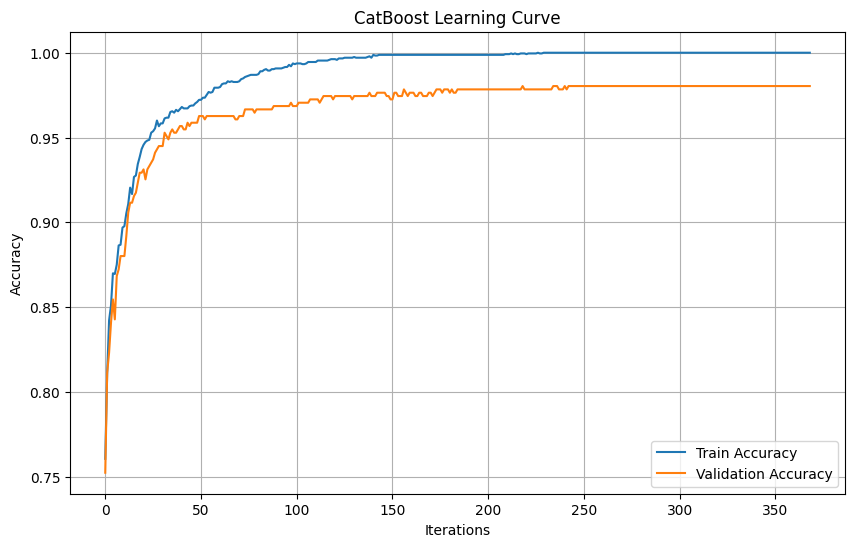

=== Fairness Matrix by Gender ===

Gender: Male
Class | TPR     | FPR     | Precision
--------------------------------
    0 | 0.9756 | 0.0193 | 0.9091
    1 | 1.0000 | 0.0047 | 0.9722
    2 | 0.0000 | 0.0000 | 0.0000
    3 | 1.0000 | 0.0000 | 1.0000
    4 | 0.8974 | 0.0048 | 0.9722
    5 | 1.0000 | 0.0000 | 1.0000

Gender: Female
Class | TPR     | FPR     | Precision
--------------------------------
    0 | 0.9773 | 0.0000 | 1.0000
    1 | 0.9800 | 0.0000 | 1.0000
    2 | 1.0000 | 0.0056 | 0.9882
    3 | 0.0000 | 0.0000 | 0.0000
    4 | 1.0000 | 0.0093 | 0.9583
    5 | 1.0000 | 0.0000 | 1.0000

=== Gender Disparity Summary ===
Class 0: TPR diff = 0.0017, Precision diff = 0.0909
Class 1: TPR diff = 0.0200, Precision diff = 0.0278
Class 2: TPR diff = 1.0000, Precision diff = 0.9882
 Significant disparity detected in Class 2
Class 3: TPR diff = 1.0000, Precision diff = 1.0000
 Significant disparity detected in Class 3
Class 4: TPR diff = 0.1026, Precision diff = 0.0139
 Significant dispa

In [96]:
# optimized CatBoost model with hyperparameters
opt_cat_model = CatBoostClassifier(
    iterations=3000,            
    learning_rate=0.10,        
    depth=6,                    
    l2_leaf_reg=3,              
    bagging_temperature=0.7,     
    eval_metric='Accuracy',
    random_seed=42,
    early_stopping_rounds=150,
    verbose=100
)


train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

opt_cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True)

y_pred = opt_cat_model.predict(X_test)
y_pred_probs = opt_cat_model.predict_proba(X_test)

train_acc = opt_cat_model.score(X_train, y_train)
val_acc = opt_cat_model.score(X_val, y_val)
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting)"
elif diff > 0.1:
    diagnosis = "High variance (overfitting)"
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit"
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting"
else:
    diagnosis = "Validation > Training, unusual case"

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference (train - val): {diff:.4f}")
print(f"Diagnosis: {diagnosis}")


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

results = opt_cat_model.get_evals_result()
plt.figure(figsize=(10,6))
plt.plot(results['learn']['Accuracy'], label='Train Accuracy')
plt.plot(results['validation']['Accuracy'], label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


def fairness_matrix_onehot_gender(y_true, y_pred_probs, X_test_df):
    gender_onehot = X_test_df[['gender_Female', 'gender_Male']].values
    gender = np.argmax(gender_onehot, axis=1)  # 0=Male, 1=Female
    y_true_idx = y_true
    y_pred_idx = np.argmax(y_pred_probs, axis=1)
    
    groups = np.unique(gender)
    classes = np.unique(y_true_idx)
    results = {g: {} for g in groups}
    
    for g in groups:
        idx = np.where(gender==g)
        y_true_g = y_true_idx[idx]
        y_pred_g = y_pred_idx[idx]
        for c in classes:
            TP = np.sum((y_pred_g==c) & (y_true_g==c))
            FN = np.sum((y_pred_g!=c) & (y_true_g==c))
            FP = np.sum((y_pred_g==c) & (y_true_g!=c))
            TN = np.sum((y_pred_g!=c) & (y_true_g!=c))
            TPR = TP / (TP+FN) if (TP+FN) > 0 else 0
            FPR = FP / (FP+TN) if (FP+TN) > 0 else 0
            Precision = TP / (TP+FP) if (TP+FP) > 0 else 0
            results[g][c] = {'TPR': TPR, 'FPR': FPR, 'Precision': Precision}
    
    print("=== Fairness Matrix by Gender ===")
    for g, class_metrics in results.items():
        gender_name = "Male" if g==0 else "Female"
        print(f"\nGender: {gender_name}")
        print("Class | TPR     | FPR     | Precision")
        print("-"*32)
        for c, metrics in class_metrics.items():
            print(f"{c:5d} | {metrics['TPR']:.4f} | {metrics['FPR']:.4f} | {metrics['Precision']:.4f}")
    
    return results

fairness_results = fairness_matrix_onehot_gender(y_test, y_pred_probs, X_test)

# Gender Disparity Summary
print("\n=== Gender Disparity Summary ===")
num_classes = y_test.max() + 1
for c in range(num_classes):
    tpr_diff = abs(fairness_results[0][c]['TPR'] - fairness_results[1][c]['TPR'])
    precision_diff = abs(fairness_results[0][c]['Precision'] - fairness_results[1][c]['Precision'])
    print(f"Class {c}: TPR diff = {tpr_diff:.4f}, Precision diff = {precision_diff:.4f}")
    if tpr_diff > 0.1 or precision_diff > 0.1:
        print(f" Significant disparity detected in Class {c}")


sensitivity = []
specificity = []

for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivity.append(sens)
    specificity.append(spec)

for i in range(num_classes):
    print(f"Class {i}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")

y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
auc = roc_auc_score(y_test_bin, y_pred_probs, average='macro', multi_class='ovr')
print(f"\nMacro-Average AUC: {auc:.4f}")


### 2.1. XGBoost with Label Encoder

[0]	validation_0-mlogloss:1.66515	validation_1-mlogloss:1.66810
[100]	validation_0-mlogloss:0.05414	validation_1-mlogloss:0.11460
[200]	validation_0-mlogloss:0.01227	validation_1-mlogloss:0.07184
[300]	validation_0-mlogloss:0.00677	validation_1-mlogloss:0.06703
[400]	validation_0-mlogloss:0.00505	validation_1-mlogloss:0.06518
[500]	validation_0-mlogloss:0.00424	validation_1-mlogloss:0.06460
[600]	validation_0-mlogloss:0.00374	validation_1-mlogloss:0.06444
[700]	validation_0-mlogloss:0.00341	validation_1-mlogloss:0.06496
[800]	validation_0-mlogloss:0.00317	validation_1-mlogloss:0.06506
[900]	validation_0-mlogloss:0.00299	validation_1-mlogloss:0.06524
[999]	validation_0-mlogloss:0.00285	validation_1-mlogloss:0.06538


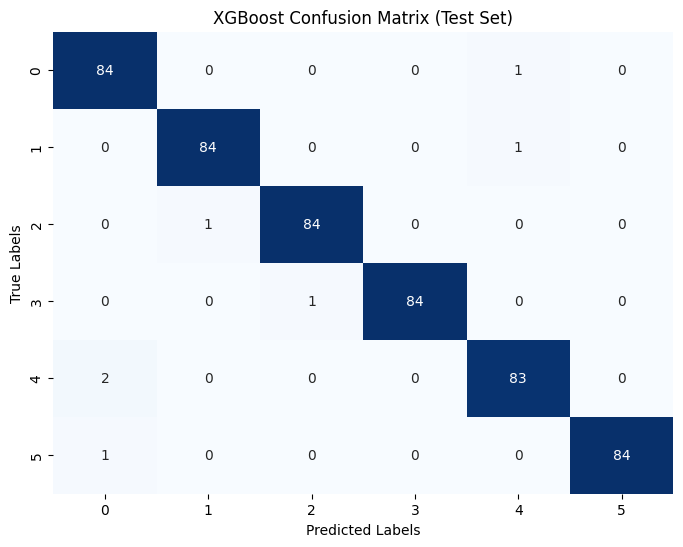

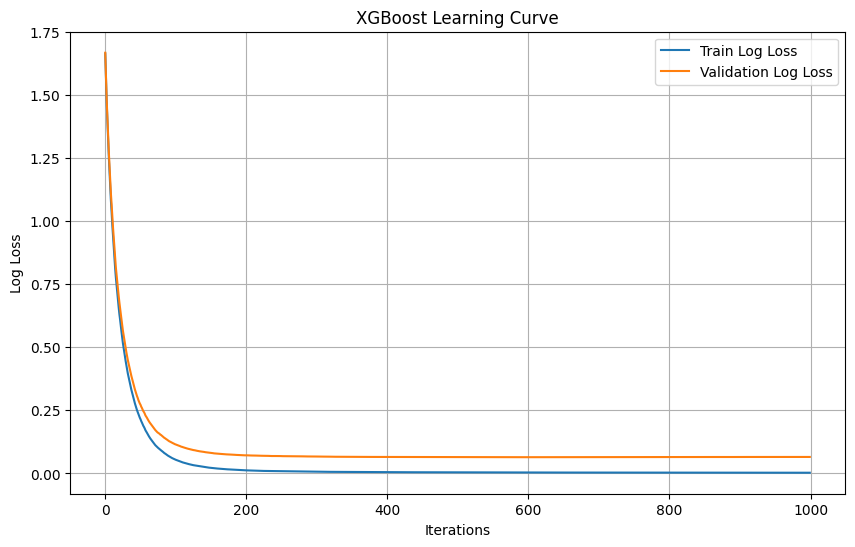

Train Accuracy: 1.0000
Validation Accuracy: 0.9764
Test Accuracy: 0.9863
Accuracy difference (train - val): 0.0236
Diagnosis: Good fit
=== Fairness Matrix by Gender ===

Gender: Male
Class | TPR     | FPR     | Precision
--------------------------------
    0 | 1.0000 | 0.0097 | 0.9535
    1 | 0.9714 | 0.0047 | 0.9714
    2 | 0.0000 | 0.0000 | 0.0000
    3 | 1.0000 | 0.0000 | 1.0000
    4 | 0.9487 | 0.0048 | 0.9737
    5 | 1.0000 | 0.0000 | 1.0000

Gender: Female
Class | TPR     | FPR     | Precision
--------------------------------
    0 | 0.9773 | 0.0046 | 0.9773
    1 | 1.0000 | 0.0000 | 1.0000
    2 | 1.0000 | 0.0056 | 0.9882
    3 | 0.0000 | 0.0000 | 0.0000
    4 | 1.0000 | 0.0046 | 0.9787
    5 | 0.9730 | 0.0000 | 1.0000

=== Gender Disparity Summary ===
Class 0: TPR diff = 0.0227, Precision diff = 0.0238
Class 1: TPR diff = 0.0286, Precision diff = 0.0286
Class 2: TPR diff = 1.0000, Precision diff = 0.9882
  ⚠️ Significant disparity detected in Class 2
Class 3: TPR diff = 1.0000

In [98]:

#  BUILDING XGBOOST MODEL
XGboost_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss'
)

eval_set = [(X_train, y_train), (X_val, y_val)]
XGboost_model.fit(X_train, y_train, eval_set=eval_set, verbose=100)

# Predictions
y_pred_probs = XGboost_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

train_acc = accuracy_score(y_train, XGboost_model.predict(X_train))
val_acc = accuracy_score(y_val, XGboost_model.predict(X_val))
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

# Bias/Variance diagnosis
if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting)"
elif diff > 0.1:
    diagnosis = "High variance (overfitting)"
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit"
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting"
else:
    diagnosis = "Validation > Training, unusual case"


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


results = XGboost_model.evals_result()
plt.figure(figsize=(10,6))
plt.plot(results['validation_0']['mlogloss'], label='Train Log Loss')
plt.plot(results['validation_1']['mlogloss'], label='Validation Log Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference (train - val): {diff:.4f}")
print(f"Diagnosis: {diagnosis}")


def fairness_matrix_onehot_gender(y_true, y_pred_probs, X_test_df):
    """ Computes TPR, FPR, Precision for gender_Female vs gender_Male """
    gender_onehot = X_test_df[['gender_Female', 'gender_Male']].values
    gender = np.argmax(gender_onehot, axis=1)  # 0=Male, 1=Female
    y_true_idx = y_true
    y_pred_idx = np.argmax(y_pred_probs, axis=1)

    groups = np.unique(gender)
    classes = np.unique(y_true_idx)
    results = {g: {} for g in groups}

    for g in groups:
        idx = np.where(gender == g)[0]
        y_true_g = y_true_idx[idx]
        y_pred_g = y_pred_idx[idx]
        for c in classes:
            TP = np.sum((y_pred_g == c) & (y_true_g == c))
            FN = np.sum((y_pred_g != c) & (y_true_g == c))
            FP = np.sum((y_pred_g == c) & (y_true_g != c))
            TN = np.sum((y_pred_g != c) & (y_true_g != c))
            TPR = TP / (TP+FN) if (TP+FN) > 0 else 0
            FPR = FP / (FP+TN) if (FP+TN) > 0 else 0
            Precision = TP / (TP+FP) if (TP+FP) > 0 else 0
            results[g][c] = {'TPR': TPR, 'FPR': FPR, 'Precision': Precision}

    print("=== Fairness Matrix by Gender ===")
    for g, class_metrics in results.items():
        gender_name = "Male" if g == 0 else "Female"
        print(f"\nGender: {gender_name}")
        print("Class | TPR     | FPR     | Precision")
        print("-"*32)
        for c, metrics in class_metrics.items():
            print(f"{c:5d} | {metrics['TPR']:.4f} | {metrics['FPR']:.4f} | {metrics['Precision']:.4f}")

    return results

# Compute fairness
fairness_results = fairness_matrix_onehot_gender(y_test, y_pred_probs, X_test)


print("\n=== Gender Disparity Summary ===")
num_classes = len(np.unique(y_test))
for c in range(num_classes):
    tpr_diff = abs(fairness_results[0][c]['TPR'] - fairness_results[1][c]['TPR'])
    precision_diff = abs(fairness_results[0][c]['Precision'] - fairness_results[1][c]['Precision'])
    print(f"Class {c}: TPR diff = {tpr_diff:.4f}, Precision diff = {precision_diff:.4f}")
    if tpr_diff > 0.1 or precision_diff > 0.1:
        print(f"  ⚠️ Significant disparity detected in Class {c}")


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")


num_classes = len(np.unique(y_test))
sensitivity = {}
specificity = {}

for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) > 0 else 0

print("\nSensitivity (TPR) per class:")
for i, val in sensitivity.items():
    print(f"Class {i}: {val:.4f}")

print("\nSpecificity (TNR) per class:")
for i, val in specificity.items():
    print(f"Class {i}: {val:.4f}")


try:
    auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    print(f"\nAUC (One-vs-Rest): {auc:.4f}")
except:
    print("\nAUC could not be calculated for this multiclass problem.")


### 2.3. Random Forest

20-Fold CV Accuracy: Mean = 0.9356, Std = 0.0265
Train Accuracy: 0.9630
Validation Accuracy: 0.9450
Test Accuracy: 0.9569
Accuracy difference (train - val): 0.0180
Diagnosis: Good fit


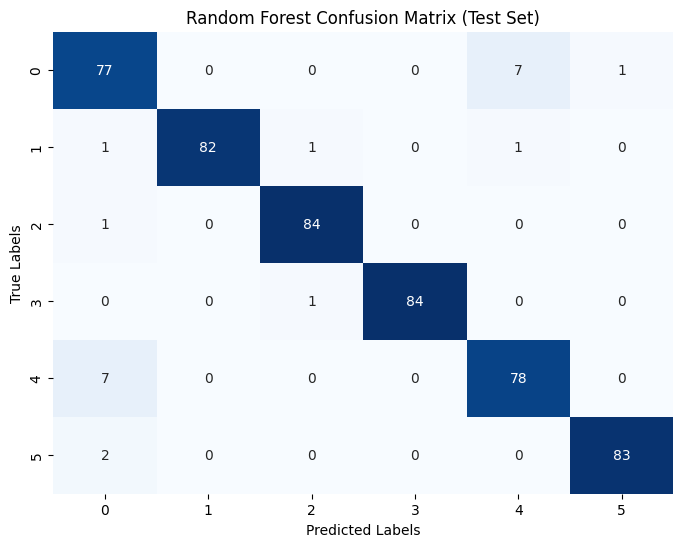

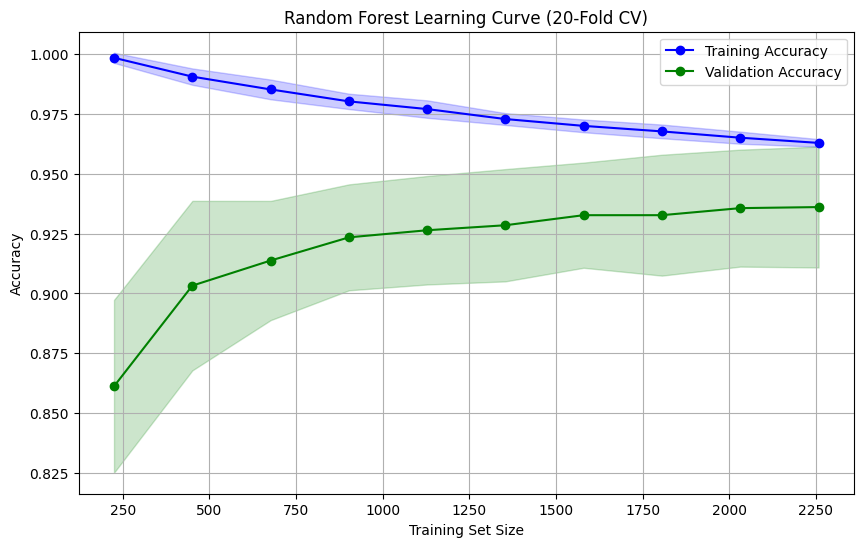

Precision (macro): 0.9578
Recall (macro): 0.9569
F1-score (macro): 0.9572

Sensitivity (TPR) per class:
Class 0: 0.9059
Class 1: 0.9647
Class 2: 0.9882
Class 3: 0.9882
Class 4: 0.9176
Class 5: 0.9765

Specificity (TNR) per class:
Class 0: 0.9741
Class 1: 1.0000
Class 2: 0.9953
Class 3: 1.0000
Class 4: 0.9812
Class 5: 0.9976

AUC (One-vs-Rest): 0.9930


In [99]:

rf_model = RandomForestClassifier(
    n_estimators=1000,
    max_depth=6,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=20, scoring='accuracy', n_jobs=-1)
print(f"20-Fold CV Accuracy: Mean = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)
y_pred_probs = rf_model.predict_proba(X_test)

train_acc = rf_model.score(X_train, y_train)
val_acc = rf_model.score(X_val, y_val)
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting)"
elif diff > 0.1:
    diagnosis = "High variance (overfitting)"
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit"
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting"
else:
    diagnosis = "Good fit"

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference (train - val): {diff:.4f}")
print(f"Diagnosis: {diagnosis}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

train_sizes, train_scores, val_scores = learning_curve(
    estimator=rf_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=20,             
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')
plt.title('Random Forest Learning Curve (20-Fold CV)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")

num_classes = len(np.unique(y_test))
sensitivity = {}
specificity = {}

for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) > 0 else 0

print("\nSensitivity (TPR) per class:")
for i, val in sensitivity.items():
    print(f"Class {i}: {val:.4f}")

print("\nSpecificity (TNR) per class:")
for i, val in specificity.items():
    print(f"Class {i}: {val:.4f}")


try:
    auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    print(f"\nAUC (One-vs-Rest): {auc:.4f}")
except:
    print("\nAUC could not be calculated for this multiclass problem.")



### 2.4 Logistic Regresion + PCA

Train Accuracy: 0.9508
Validation Accuracy: 0.9528
Test Accuracy: 0.9431
Accuracy difference (train - val): -0.0021
Diagnosis: Good fit


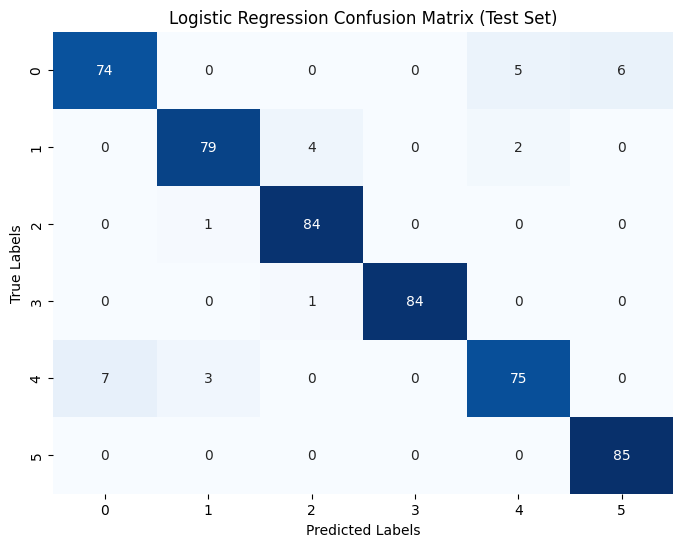

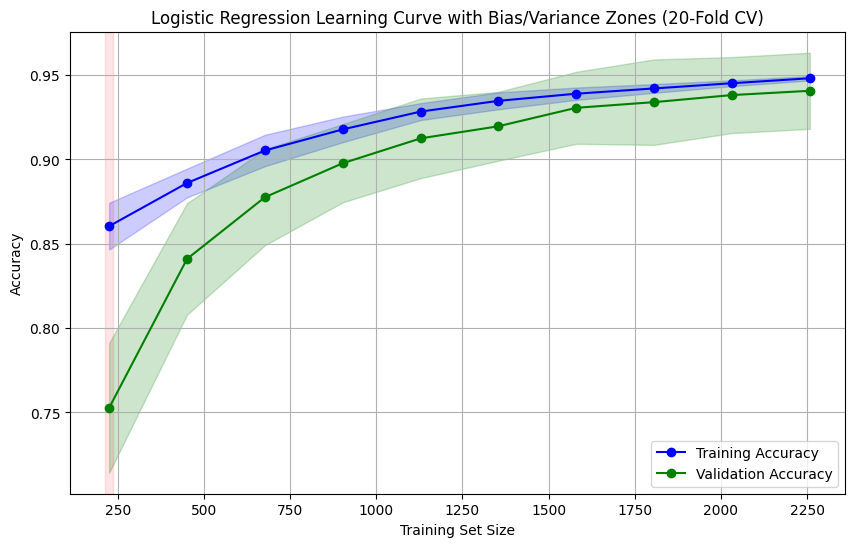

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        85
           1       0.95      0.93      0.94        85
           2       0.94      0.99      0.97        85
           3       1.00      0.99      0.99        85
           4       0.91      0.88      0.90        85
           5       0.93      1.00      0.97        85

    accuracy                           0.94       510
   macro avg       0.94      0.94      0.94       510
weighted avg       0.94      0.94      0.94       510

Precision (macro): 0.9430
Recall (macro): 0.9431
F1-score (macro): 0.9426

Sensitivity (TPR) per class:
Class 0: 0.8706
Class 1: 0.9294
Class 2: 0.9882
Class 3: 0.9882
Class 4: 0.8824
Class 5: 1.0000

Specificity (TNR) per class:
Class 0: 0.9835
Class 1: 0.9906
Class 2: 0.9882
Class 3: 1.0000
Class 4: 0.9835
Class 5: 0.9859

AUC (One-vs-Rest): 0.9942


In [100]:


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)
y_pred_probs = lr_model.predict_proba(X_test_scaled)

train_acc = lr_model.score(X_train_scaled, y_train)
val_acc = lr_model.score(X_val_scaled, y_val)
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting)"
elif diff > 0.1:
    diagnosis = "High variance (overfitting)"
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit"
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting"
else:
    diagnosis = "Good fit"

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference (train - val): {diff:.4f}")
print(f"Diagnosis: {diagnosis}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
from sklearn.model_selection import learning_curve


train_sizes, train_scores, val_scores = learning_curve(
    estimator=lr_model,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=20,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

# Highlight zones
for i, size in enumerate(train_sizes):
    gap = train_mean[i] - val_mean[i]
    if gap > 0.05:
        plt.axvspan(size-0.05*size, size+0.05*size, color='red', alpha=0.1)  # overfitting
    elif val_mean[i] < 0.7 and train_mean[i] < 0.7:
        plt.axvspan(size-0.05*size, size+0.05*size, color='yellow', alpha=0.1)  # underfitting

plt.title('Logistic Regression Learning Curve with Bias/Variance Zones (20-Fold CV)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


print("Classification Report:")
print(classification_report(y_test, y_pred))


precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")


num_classes = len(np.unique(y_test))
sensitivity = {}
specificity = {}

for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) > 0 else 0

print("\nSensitivity (TPR) per class:")
for i, val in sensitivity.items():
    print(f"Class {i}: {val:.4f}")

print("\nSpecificity (TNR) per class:")
for i, val in specificity.items():
    print(f"Class {i}: {val:.4f}")


try:
    auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    print(f"\nAUC (One-vs-Rest): {auc:.4f}")
except:
    print("\nAUC could not be calculated for this multiclass problem.")


### 2.5. LSTM with one hot encoder

Epoch 1/150
75/75 - 3s - 45ms/step - accuracy: 0.2684 - loss: 1.6935 - val_accuracy: 0.3595 - val_loss: 1.4390
Epoch 2/150
75/75 - 0s - 3ms/step - accuracy: 0.4455 - loss: 1.2834 - val_accuracy: 0.5128 - val_loss: 1.1039
Epoch 3/150
75/75 - 0s - 3ms/step - accuracy: 0.5456 - loss: 1.0655 - val_accuracy: 0.6189 - val_loss: 0.9620
Epoch 4/150
75/75 - 0s - 3ms/step - accuracy: 0.6041 - loss: 0.9459 - val_accuracy: 0.6326 - val_loss: 0.8662
Epoch 5/150
75/75 - 0s - 3ms/step - accuracy: 0.6912 - loss: 0.8189 - val_accuracy: 0.8094 - val_loss: 0.6861
Epoch 6/150
75/75 - 0s - 3ms/step - accuracy: 0.7198 - loss: 0.7226 - val_accuracy: 0.8134 - val_loss: 0.5915
Epoch 7/150
75/75 - 0s - 3ms/step - accuracy: 0.7514 - loss: 0.6455 - val_accuracy: 0.8193 - val_loss: 0.5271
Epoch 8/150
75/75 - 0s - 3ms/step - accuracy: 0.7695 - loss: 0.5882 - val_accuracy: 0.8251 - val_loss: 0.5152
Epoch 9/150
75/75 - 0s - 2ms/step - accuracy: 0.7892 - loss: 0.5540 - val_accuracy: 0.8310 - val_loss: 0.4702
Epoch 10/

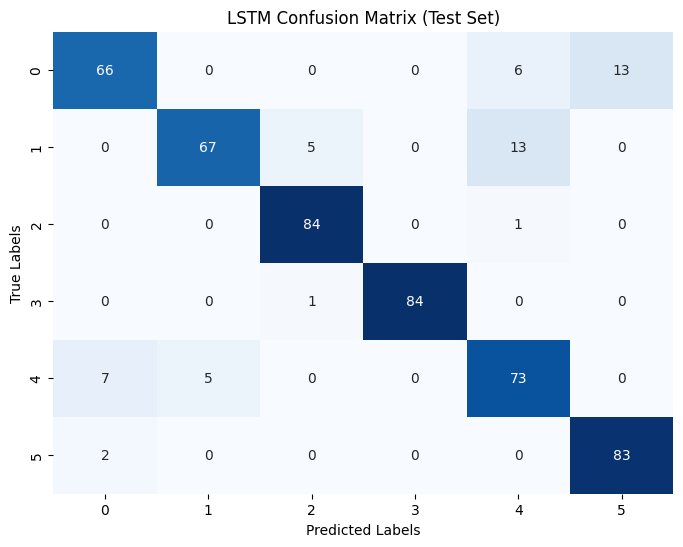

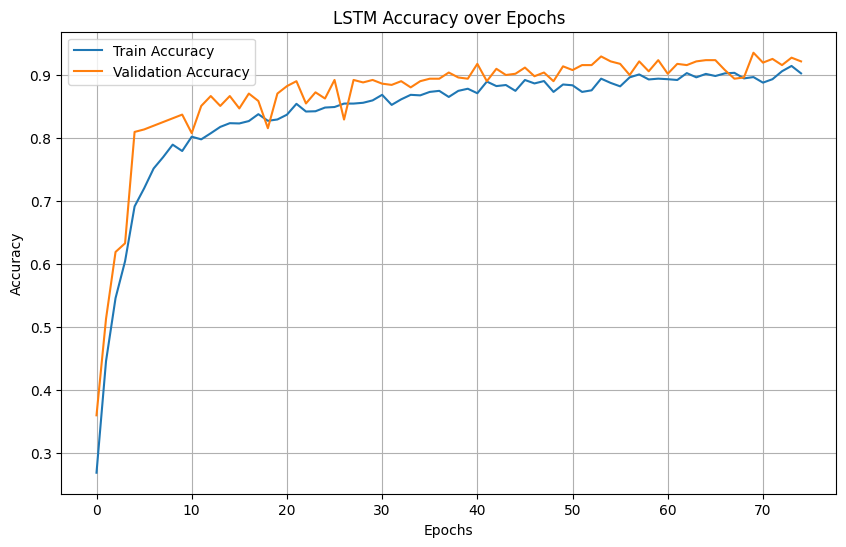

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        85
           1       0.93      0.79      0.85        85
           2       0.93      0.99      0.96        85
           3       1.00      0.99      0.99        85
           4       0.78      0.86      0.82        85
           5       0.86      0.98      0.92        85

    accuracy                           0.90       510
   macro avg       0.90      0.90      0.89       510
weighted avg       0.90      0.90      0.89       510

Precision (macro): 0.8989
Recall (macro): 0.8961
F1-score (macro): 0.8950

Sensitivity (TPR) per class:
Class 0: 0.7765
Class 1: 0.7882
Class 2: 0.9882
Class 3: 0.9882
Class 4: 0.8588
Class 5: 0.9765

Specificity (TNR) per class:
Class 0: 0.9788
Class 1: 0.9882
Class 2: 0.9859
Class 3: 1.0000
Class 4: 0.9529
Class 5: 0.9694

AUC (One-vs-Rest): 0.9906


In [101]:

X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

num_classes = len(np.unique(y))
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Use sparse_categorical_crossentropy for integer labels
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

y_pred_probs = lstm_model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting) – model not learning well."
elif diff > 0.1:
    diagnosis = "High variance (overfitting) – memorizing training data."
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit – generalizes well."
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting – minor gap."
else:
    diagnosis = "Validation accuracy higher than training – check randomness/dropout."

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference: {diff:.4f}")
print(f"Diagnosis: {diagnosis}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('LSTM Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")


sensitivity = {}
specificity = {}
for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) > 0 else 0

print("\nSensitivity (TPR) per class:")
for i, val in sensitivity.items():
    print(f"Class {i}: {val:.4f}")
print("\nSpecificity (TNR) per class:")
for i, val in specificity.items():
    print(f"Class {i}: {val:.4f}")


try:
    
    from tensorflow.keras.utils import to_categorical
    y_test_onehot = to_categorical(y_test, num_classes=num_classes)
    auc = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')
    print(f"\nAUC (One-vs-Rest): {auc:.4f}")
except:
    print("\nAUC could not be calculated for this multiclass problem.")


Epoch 1/200
149/149 - 12s - 83ms/step - accuracy: 0.4409 - loss: 1.2777 - val_accuracy: 0.6287 - val_loss: 0.8713
Epoch 2/200
149/149 - 1s - 4ms/step - accuracy: 0.6790 - loss: 0.7736 - val_accuracy: 0.7819 - val_loss: 0.5543
Epoch 3/200
149/149 - 1s - 4ms/step - accuracy: 0.7800 - loss: 0.5437 - val_accuracy: 0.8350 - val_loss: 0.4289
Epoch 4/200
149/149 - 1s - 4ms/step - accuracy: 0.7964 - loss: 0.4696 - val_accuracy: 0.8291 - val_loss: 0.4368
Epoch 5/200
149/149 - 1s - 4ms/step - accuracy: 0.8162 - loss: 0.4511 - val_accuracy: 0.8684 - val_loss: 0.3523
Epoch 6/200
149/149 - 1s - 4ms/step - accuracy: 0.8162 - loss: 0.4522 - val_accuracy: 0.8625 - val_loss: 0.3727
Epoch 7/200
149/149 - 1s - 4ms/step - accuracy: 0.8473 - loss: 0.3746 - val_accuracy: 0.8585 - val_loss: 0.3358
Epoch 8/200
149/149 - 1s - 4ms/step - accuracy: 0.8414 - loss: 0.3810 - val_accuracy: 0.8291 - val_loss: 0.4095
Epoch 9/200
149/149 - 1s - 4ms/step - accuracy: 0.8507 - loss: 0.3757 - val_accuracy: 0.8743 - val_los

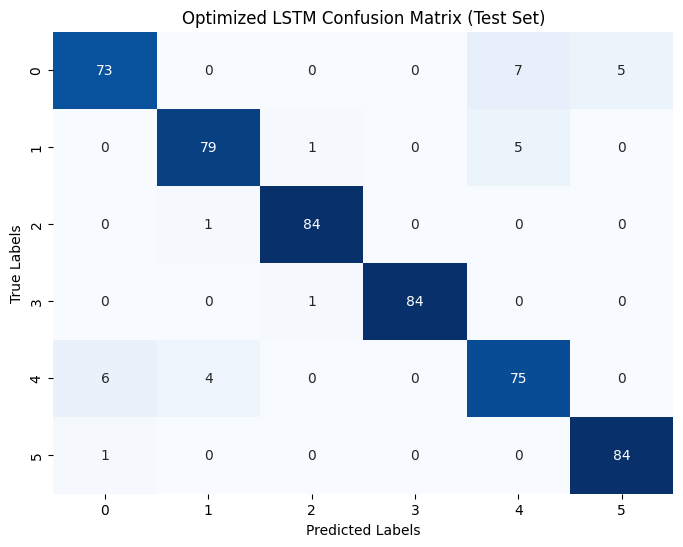

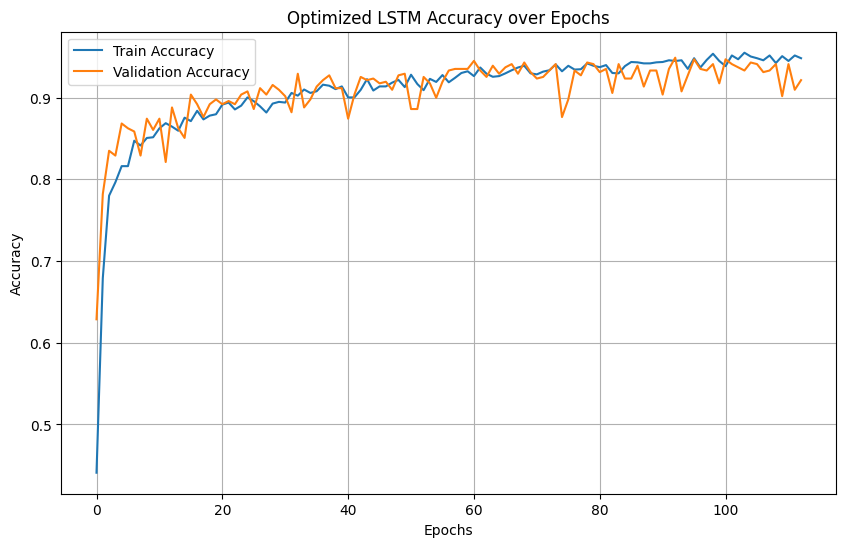

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88        85
           1       0.94      0.93      0.93        85
           2       0.98      0.99      0.98        85
           3       1.00      0.99      0.99        85
           4       0.86      0.88      0.87        85
           5       0.94      0.99      0.97        85

    accuracy                           0.94       510
   macro avg       0.94      0.94      0.94       510
weighted avg       0.94      0.94      0.94       510

Precision (macro): 0.9393
Recall (macro): 0.9392
F1-score (macro): 0.9390

Sensitivity (TPR) per class:
Class 0: 0.8588
Class 1: 0.9294
Class 2: 0.9882
Class 3: 0.9882
Class 4: 0.8824
Class 5: 0.9882

Specificity (TNR) per class:
Class 0: 0.9835
Class 1: 0.9882
Class 2: 0.9953
Class 3: 1.0000
Class 4: 0.9718
Class 5: 0.9882

AUC (One-vs-Rest): 0.9950


In [102]:

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


num_classes = len(classes)
opt_lstm_model = Sequential([
    LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
         return_sequences=True, recurrent_dropout=0.2),
    LSTM(64, return_sequences=False, recurrent_dropout=0.2),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

opt_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


history = opt_lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=2
)


y_pred_probs = opt_lstm_model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting) – model not learning well."
elif diff > 0.1:
    diagnosis = "High variance (overfitting) – memorizing training data."
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit – generalizes well."
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting – minor gap."
else:
    diagnosis = "Validation accuracy higher than training – check randomness/dropout."

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference: {diff:.4f}")
print(f"Diagnosis: {diagnosis}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Optimized LSTM Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Optimized LSTM Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


print("Classification Report:")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")

sensitivity = {}
specificity = {}
for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) > 0 else 0

print("\nSensitivity (TPR) per class:")
for i, val in sensitivity.items():
    print(f"Class {i}: {val:.4f}")
print("\nSpecificity (TNR) per class:")
for i, val in specificity.items():
    print(f"Class {i}: {val:.4f}")


try:
    from tensorflow.keras.utils import to_categorical
    y_test_onehot = to_categorical(y_test, num_classes=num_classes)
    auc = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')
    print(f"\nAUC (One-vs-Rest): {auc:.4f}")
except:
    print("\nAUC could not be calculated for this multiclass problem.")


## 2.6 ANN-PSO

Epoch 1/150
75/75 - 1s - 13ms/step - accuracy: 0.1645 - loss: 6.2151 - val_accuracy: 0.1945 - val_loss: 1.9607
Epoch 2/150
75/75 - 0s - 2ms/step - accuracy: 0.2503 - loss: 2.7444 - val_accuracy: 0.2495 - val_loss: 1.5753
Epoch 3/150
75/75 - 0s - 2ms/step - accuracy: 0.2638 - loss: 2.0039 - val_accuracy: 0.3281 - val_loss: 1.4111
Epoch 4/150
75/75 - 0s - 2ms/step - accuracy: 0.3273 - loss: 1.6795 - val_accuracy: 0.3458 - val_loss: 1.3389
Epoch 5/150
75/75 - 0s - 2ms/step - accuracy: 0.3412 - loss: 1.5120 - val_accuracy: 0.4185 - val_loss: 1.2472
Epoch 6/150
75/75 - 0s - 2ms/step - accuracy: 0.3723 - loss: 1.3970 - val_accuracy: 0.4853 - val_loss: 1.1808
Epoch 7/150
75/75 - 0s - 2ms/step - accuracy: 0.4396 - loss: 1.2751 - val_accuracy: 0.4656 - val_loss: 1.1092
Epoch 8/150
75/75 - 0s - 2ms/step - accuracy: 0.4952 - loss: 1.1551 - val_accuracy: 0.5501 - val_loss: 1.0457
Epoch 9/150
75/75 - 0s - 2ms/step - accuracy: 0.5145 - loss: 1.1101 - val_accuracy: 0.5501 - val_loss: 0.9637
Epoch 10/

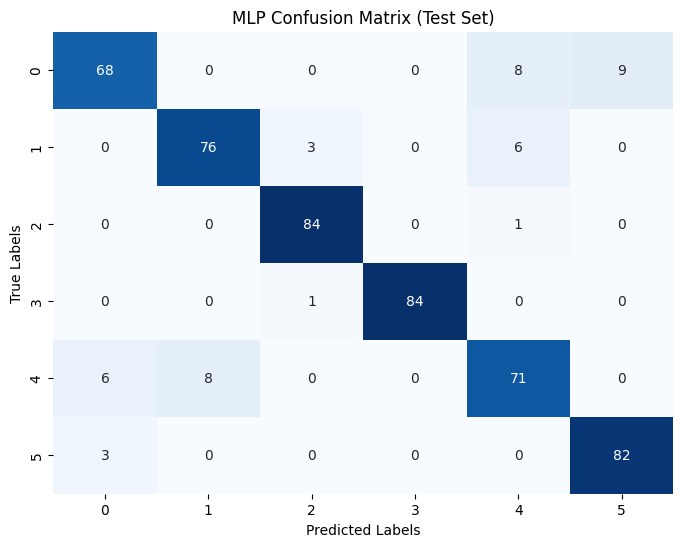

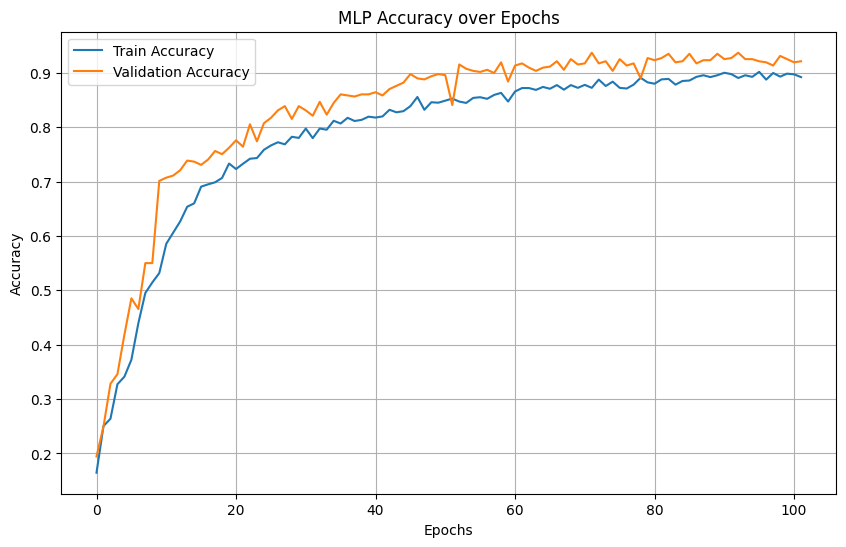

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84        85
           1       0.90      0.89      0.90        85
           2       0.95      0.99      0.97        85
           3       1.00      0.99      0.99        85
           4       0.83      0.84      0.83        85
           5       0.90      0.96      0.93        85

    accuracy                           0.91       510
   macro avg       0.91      0.91      0.91       510
weighted avg       0.91      0.91      0.91       510

Precision (macro): 0.9115
Recall (macro): 0.9118
F1-score (macro): 0.9111

Sensitivity (TPR) per class:
Class 0: 0.8000
Class 1: 0.8941
Class 2: 0.9882
Class 3: 0.9882
Class 4: 0.8353
Class 5: 0.9647

Specificity (TNR) per class:
Class 0: 0.9788
Class 1: 0.9812
Class 2: 0.9906
Class 3: 1.0000
Class 4: 0.9647
Class 5: 0.9788

AUC (One-vs-Rest): 0.9891


In [103]:

num_classes = len(np.unique(y))
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

y_pred_probs = mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting) – model not learning well."
elif diff > 0.1:
    diagnosis = "High variance (overfitting) – memorizing training data."
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit – generalizes well."
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting – minor gap."
else:
    diagnosis = "Validation accuracy higher than training – check randomness/dropout."

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference: {diff:.4f}")
print(f"Diagnosis: {diagnosis}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('MLP Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")


sensitivity = {}
specificity = {}
for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) > 0 else 0

print("\nSensitivity (TPR) per class:")
for i, val in sensitivity.items():
    print(f"Class {i}: {val:.4f}")
print("\nSpecificity (TNR) per class:")
for i, val in specificity.items():
    print(f"Class {i}: {val:.4f}")


try:
    from tensorflow.keras.utils import to_categorical
    y_test_onehot = to_categorical(y_test, num_classes=num_classes)
    auc = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')
    print(f"\nAUC (One-vs-Rest): {auc:.4f}")
except:
    print("\nAUC could not be calculated for this multiclass problem.")


Epoch 1/200
149/149 - 1s - 9ms/step - accuracy: 0.2204 - loss: 2.7644 - val_accuracy: 0.2908 - val_loss: 1.5770 - learning_rate: 1.0000e-03
Epoch 2/200
149/149 - 0s - 2ms/step - accuracy: 0.2970 - loss: 1.6356 - val_accuracy: 0.4381 - val_loss: 1.3797 - learning_rate: 1.0000e-03
Epoch 3/200
149/149 - 0s - 2ms/step - accuracy: 0.3690 - loss: 1.4339 - val_accuracy: 0.4028 - val_loss: 1.2499 - learning_rate: 1.0000e-03
Epoch 4/200
149/149 - 0s - 2ms/step - accuracy: 0.4131 - loss: 1.2760 - val_accuracy: 0.4931 - val_loss: 1.0987 - learning_rate: 1.0000e-03
Epoch 5/200
149/149 - 0s - 2ms/step - accuracy: 0.4493 - loss: 1.1710 - val_accuracy: 0.5305 - val_loss: 1.0171 - learning_rate: 1.0000e-03
Epoch 6/200
149/149 - 0s - 2ms/step - accuracy: 0.5217 - loss: 1.0773 - val_accuracy: 0.5992 - val_loss: 0.9491 - learning_rate: 1.0000e-03
Epoch 7/200
149/149 - 0s - 2ms/step - accuracy: 0.5562 - loss: 0.9924 - val_accuracy: 0.7289 - val_loss: 0.7939 - learning_rate: 1.0000e-03
Epoch 8/200
149/149 

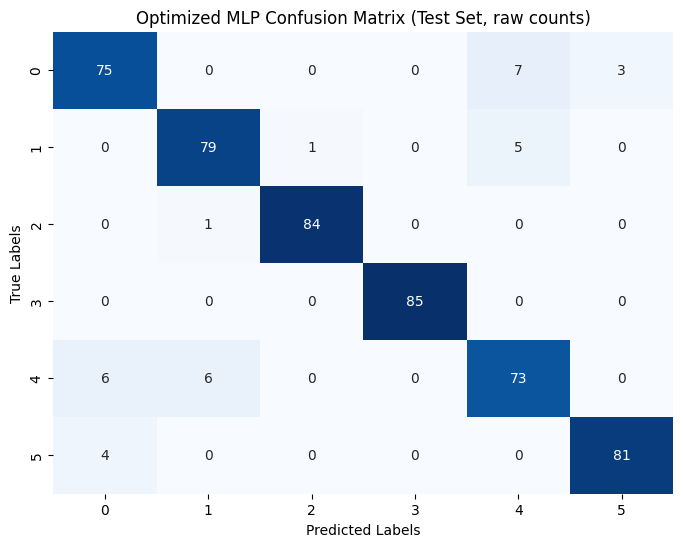

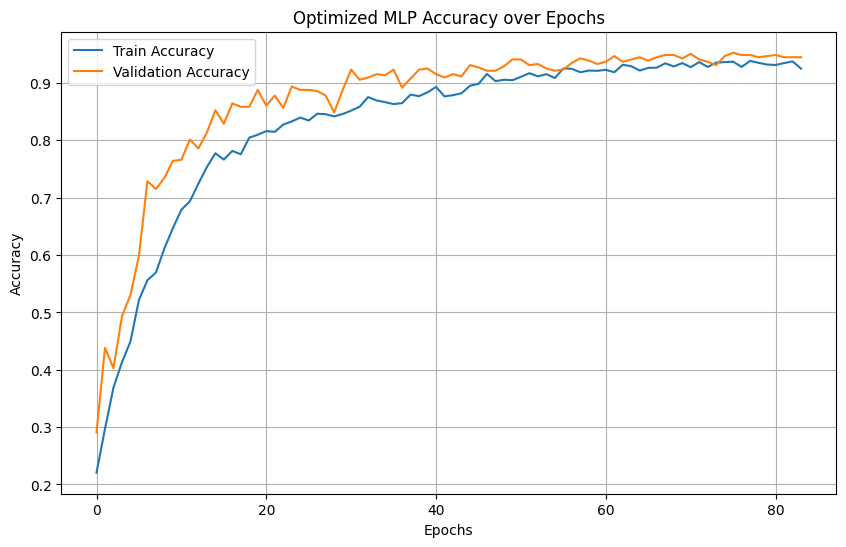

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        85
           1       0.92      0.93      0.92        85
           2       0.99      0.99      0.99        85
           3       1.00      1.00      1.00        85
           4       0.86      0.86      0.86        85
           5       0.96      0.95      0.96        85

    accuracy                           0.94       510
   macro avg       0.94      0.94      0.94       510
weighted avg       0.94      0.94      0.94       510

Precision (macro): 0.9354
Recall (macro): 0.9353
F1-score (macro): 0.9353

Sensitivity (TPR) per class:
Class 0: 0.8824
Class 1: 0.9294
Class 2: 0.9882
Class 3: 1.0000
Class 4: 0.8588
Class 5: 0.9529

Specificity (TNR) per class:
Class 0: 0.9765
Class 1: 0.9835
Class 2: 0.9976
Class 3: 1.0000
Class 4: 0.9718
Class 5: 0.9929

AUC (One-vs-Rest): 0.9924


In [104]:


num_classes = len(np.unique(y_train))

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

opt_mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.15), 
    Dense(64, activation='relu'),
    Dropout(0.15),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

opt_mlp_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)


history = opt_mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict,
    verbose=2
)

y_pred_probs = opt_mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting) – model not learning well."
elif diff > 0.1:
    diagnosis = "High variance (overfitting) – memorizing training data."
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit – generalizes well."
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting – minor gap."
else:
    diagnosis = "Validation accuracy higher than training – check randomness/dropout."

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference: {diff:.4f}")
print(f"Diagnosis: {diagnosis}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Optimized MLP Confusion Matrix (Test Set, raw counts)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Optimized MLP Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")


sensitivity = {}
specificity = {}
for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity[i] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) > 0 else 0

print("\nSensitivity (TPR) per class:")
for i, val in sensitivity.items():
    print(f"Class {i}: {val:.4f}")
print("\nSpecificity (TNR) per class:")
for i, val in specificity.items():
    print(f"Class {i}: {val:.4f}")


try:
    y_test_onehot = to_categorical(y_test, num_classes=num_classes)
    auc = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')
    print(f"\nAUC (One-vs-Rest): {auc:.4f}")
except:
    print("\nAUC could not be calculated for this multiclass problem.")


### 3. Ensemble techniques

Train Accuracy: 1.0000
Validation Accuracy: 0.9804
Test Accuracy: 0.9863
Accuracy difference (train - val): 0.0196
Diagnosis: Good fit
Accuracy : 0.9863
Precision: 0.9864
Recall   : 0.9863
F1 Score : 0.9863


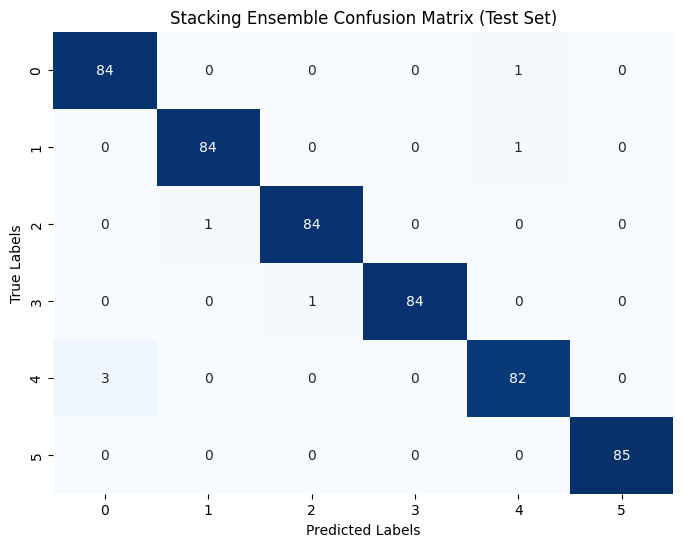

Class 0: Sensitivity = 0.9882, Specificity = 0.9929
Class 1: Sensitivity = 0.9882, Specificity = 0.9976
Class 2: Sensitivity = 0.9882, Specificity = 0.9976
Class 3: Sensitivity = 0.9882, Specificity = 1.0000
Class 4: Sensitivity = 0.9647, Specificity = 0.9953
Class 5: Sensitivity = 1.0000, Specificity = 1.0000

Macro-Average AUC: 0.9996
=== Fairness Matrix by Gender ===

Gender: Male
Class | TPR     | FPR     | Precision
--------------------------------
    0 | 1.0000 | 0.0145 | 0.9318
    1 | 1.0000 | 0.0047 | 0.9722
    2 | 0.0000 | 0.0000 | 0.0000
    3 | 1.0000 | 0.0000 | 1.0000
    4 | 0.9231 | 0.0000 | 1.0000
    5 | 1.0000 | 0.0000 | 1.0000

Gender: Female
Class | TPR     | FPR     | Precision
--------------------------------
    0 | 0.9773 | 0.0000 | 1.0000
    1 | 0.9800 | 0.0000 | 1.0000
    2 | 1.0000 | 0.0056 | 0.9882
    3 | 0.0000 | 0.0000 | 0.0000
    4 | 1.0000 | 0.0093 | 0.9583
    5 | 1.0000 | 0.0000 | 1.0000

=== Gender Disparity Summary ===
Class 0: TPR diff = 0.022

In [105]:

stack_model = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', XGboost_model),
        ('cat', opt_cat_model)
    ],
    final_estimator=rf_model, 
    cv=5,
    n_jobs=-1,
    passthrough=True
)


stack_model.fit(X_train, y_train)


y_pred = stack_model.predict(X_test)


try:
    y_pred_probs = stack_model.predict_proba(X_test)
except:
    y_pred_probs = None


train_acc = stack_model.score(X_train, y_train)
val_acc = stack_model.score(X_val, y_val)
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting)"
elif diff > 0.1:
    diagnosis = "High variance (overfitting)"
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit"
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting"
else:
    diagnosis = "Validation > Training, unusual case"

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference (train - val): {diff:.4f}")
print(f"Diagnosis: {diagnosis}")


precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Stacking Ensemble Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


num_classes = len(np.unique(y_test))
sensitivity = []
specificity = []

for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivity.append(sens)
    specificity.append(spec)

for i in range(num_classes):
    print(f"Class {i}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")


if y_pred_probs is not None:
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
    auc = roc_auc_score(y_test_bin, y_pred_probs, average='macro', multi_class='ovr')
    print(f"\nMacro-Average AUC: {auc:.4f}")


def fairness_matrix_onehot_gender(y_true, y_pred_probs, X_test_df):
    gender_onehot = X_test_df[['gender_Female', 'gender_Male']].values
    gender = np.argmax(gender_onehot, axis=1)  # 0=Male, 1=Female
    y_true_idx = y_true
    y_pred_idx = np.argmax(y_pred_probs, axis=1)
    
    groups = np.unique(gender)
    classes = np.unique(y_true_idx)
    results = {g: {} for g in groups}
    
    for g in groups:
        idx = np.where(gender==g)
        y_true_g = y_true_idx[idx]
        y_pred_g = y_pred_idx[idx]
        for c in classes:
            TP = np.sum((y_pred_g==c) & (y_true_g==c))
            FN = np.sum((y_pred_g!=c) & (y_true_g==c))
            FP = np.sum((y_pred_g==c) & (y_true_g!=c))
            TN = np.sum((y_pred_g!=c) & (y_true_g!=c))
            TPR = TP / (TP+FN) if (TP+FN) > 0 else 0
            FPR = FP / (FP+TN) if (FP+TN) > 0 else 0
            Precision = TP / (TP+FP) if (TP+FP) > 0 else 0
            results[g][c] = {'TPR': TPR, 'FPR': FPR, 'Precision': Precision}
    
    print("=== Fairness Matrix by Gender ===")
    for g, class_metrics in results.items():
        gender_name = "Male" if g==0 else "Female"
        print(f"\nGender: {gender_name}")
        print("Class | TPR     | FPR     | Precision")
        print("-"*32)
        for c, metrics in class_metrics.items():
            print(f"{c:5d} | {metrics['TPR']:.4f} | {metrics['FPR']:.4f} | {metrics['Precision']:.4f}")
    
    return results

if y_pred_probs is not None:
    fairness_results = fairness_matrix_onehot_gender(y_test, y_pred_probs, X_test)

    
    print("\n=== Gender Disparity Summary ===")
    for c in range(num_classes):
        tpr_diff = abs(fairness_results[0][c]['TPR'] - fairness_results[1][c]['TPR'])
        precision_diff = abs(fairness_results[0][c]['Precision'] - fairness_results[1][c]['Precision'])
        print(f"Class {c}: TPR diff = {tpr_diff:.4f}, Precision diff = {precision_diff:.4f}")
        if tpr_diff > 0.1 or precision_diff > 0.1:
            print(f" Significant disparity detected in Class {c}")


Train Accuracy: 1.0000
Validation Accuracy: 0.9804
Test Accuracy: 0.9843
Accuracy difference (train - val): 0.0196
Diagnosis: Good fit
Accuracy : 0.9843
Precision: 0.9845
Recall   : 0.9843
F1 Score : 0.9844


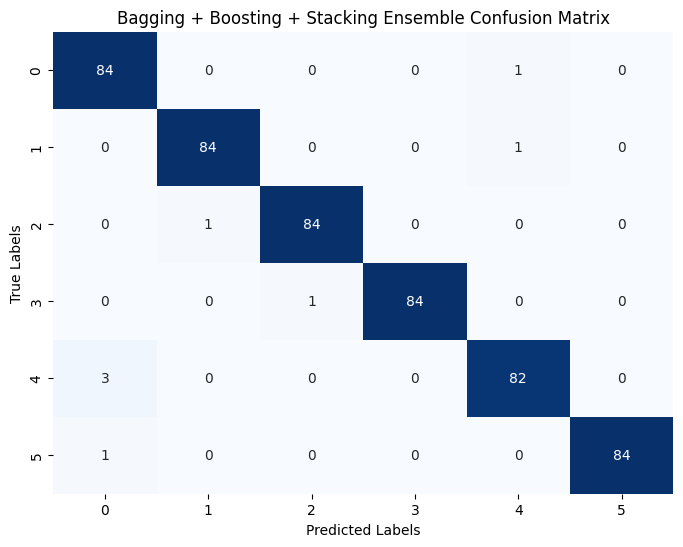

Class 0: Sensitivity = 0.9882, Specificity = 0.9906
Class 1: Sensitivity = 0.9882, Specificity = 0.9976
Class 2: Sensitivity = 0.9882, Specificity = 0.9976
Class 3: Sensitivity = 0.9882, Specificity = 1.0000
Class 4: Sensitivity = 0.9647, Specificity = 0.9953
Class 5: Sensitivity = 0.9882, Specificity = 1.0000

Macro-Average AUC: 0.9995
=== Fairness Matrix by Gender ===

Gender: Male
Class | TPR     | FPR     | Precision
--------------------------------
    0 | 1.0000 | 0.0145 | 0.9318
    1 | 1.0000 | 0.0047 | 0.9722
    2 | 0.0000 | 0.0000 | 0.0000
    3 | 1.0000 | 0.0000 | 1.0000
    4 | 0.9231 | 0.0000 | 1.0000
    5 | 1.0000 | 0.0000 | 1.0000

Gender: Female
Class | TPR     | FPR     | Precision
--------------------------------
    0 | 0.9773 | 0.0046 | 0.9773
    1 | 0.9800 | 0.0000 | 1.0000
    2 | 1.0000 | 0.0056 | 0.9882
    3 | 0.0000 | 0.0000 | 0.0000
    4 | 1.0000 | 0.0093 | 0.9583
    5 | 0.9730 | 0.0000 | 1.0000

=== Gender Disparity Summary ===
Class 0: TPR diff = 0.022

In [106]:

bagging_model = BaggingClassifier(
    estimator=rf_model,
    n_estimators=10,
    max_samples=0.8,
    max_features=0.8,
    random_state=42,
    n_jobs=-1
)


boosting_model = AdaBoostClassifier(
    estimator=rf_model,
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)


opt_stack_model = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', XGboost_model),
        ('cat', opt_cat_model),
        ('bag', bagging_model),
        ('boost', boosting_model)
    ],
    final_estimator=rf_model,  
    cv=5,
    n_jobs=-1,
    passthrough=True
)


opt_stack_model.fit(X_train, y_train)

y_pred = opt_stack_model.predict(X_test)

# If available, get probabilities
try:
    y_pred_probs = opt_stack_model.predict_proba(X_test)
except:
    y_pred_probs = None


train_acc = opt_stack_model.score(X_train, y_train)
val_acc = opt_stack_model.score(X_val, y_val)
test_acc = accuracy_score(y_test, y_pred)
diff = train_acc - val_acc

if train_acc < 0.7 and val_acc < 0.7:
    diagnosis = "High bias (underfitting)"
elif diff > 0.1:
    diagnosis = "High variance (overfitting)"
elif 0 <= diff <= 0.05:
    diagnosis = "Good fit"
elif 0.05 < diff <= 0.1:
    diagnosis = "Slight overfitting"
else:
    diagnosis = "Validation > Training, unusual case"

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy difference (train - val): {diff:.4f}")
print(f"Diagnosis: {diagnosis}")


precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Bagging + Boosting + Stacking Ensemble Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

num_classes = len(np.unique(y_test))
sensitivity = []
specificity = []

for i in range(num_classes):
    TP = cm[i,i]
    FN = np.sum(cm[i,:]) - TP
    FP = np.sum(cm[:,i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)
    
    sens = TP / (TP + FN) if (TP + FN) > 0 else 0
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivity.append(sens)
    specificity.append(spec)

for i in range(num_classes):
    print(f"Class {i}: Sensitivity = {sensitivity[i]:.4f}, Specificity = {specificity[i]:.4f}")


if y_pred_probs is not None:
    y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
    auc = roc_auc_score(y_test_bin, y_pred_probs, average='macro', multi_class='ovr')
    print(f"\nMacro-Average AUC: {auc:.4f}")


def fairness_matrix_onehot_gender(y_true, y_pred_probs, X_test_df):
    gender_onehot = X_test_df[['gender_Female', 'gender_Male']].values
    gender = np.argmax(gender_onehot, axis=1)  # 0=Male, 1=Female
    y_true_idx = y_true
    y_pred_idx = np.argmax(y_pred_probs, axis=1)
    
    groups = np.unique(gender)
    classes = np.unique(y_true_idx)
    results = {g: {} for g in groups}
    
    for g in groups:
        idx = np.where(gender==g)
        y_true_g = y_true_idx[idx]
        y_pred_g = y_pred_idx[idx]
        for c in classes:
            TP = np.sum((y_pred_g==c) & (y_true_g==c))
            FN = np.sum((y_pred_g!=c) & (y_true_g==c))
            FP = np.sum((y_pred_g==c) & (y_true_g!=c))
            TN = np.sum((y_pred_g!=c) & (y_true_g!=c))
            TPR = TP / (TP+FN) if (TP+FN) > 0 else 0
            FPR = FP / (FP+TN) if (FP+TN) > 0 else 0
            Precision = TP / (TP+FP) if (TP+FP) > 0 else 0
            results[g][c] = {'TPR': TPR, 'FPR': FPR, 'Precision': Precision}
    
    print("=== Fairness Matrix by Gender ===")
    for g, class_metrics in results.items():
        gender_name = "Male" if g==0 else "Female"
        print(f"\nGender: {gender_name}")
        print("Class | TPR     | FPR     | Precision")
        print("-"*32)
        for c, metrics in class_metrics.items():
            print(f"{c:5d} | {metrics['TPR']:.4f} | {metrics['FPR']:.4f} | {metrics['Precision']:.4f}")
    
    return results

if y_pred_probs is not None:
    fairness_results = fairness_matrix_onehot_gender(y_test, y_pred_probs, X_test)

    # Gender Disparity Summary
    print("\n=== Gender Disparity Summary ===")
    for c in range(num_classes):
        tpr_diff = abs(fairness_results[0][c]['TPR'] - fairness_results[1][c]['TPR'])
        precision_diff = abs(fairness_results[0][c]['Precision'] - fairness_results[1][c]['Precision'])
        print(f"Class {c}: TPR diff = {tpr_diff:.4f}, Precision diff = {precision_diff:.4f}")
        if tpr_diff > 0.1 or precision_diff > 0.1:
            print(f" Significant disparity detected in Class {c}")


### model selection

Evaluating Opt_CatBoost ...
Evaluating XGBoost ...
Evaluating RandomForest ...
Evaluating LogisticRegression ...
Evaluating LSTM ...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Evaluating MLP ...
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluating Opt_Stacking ...

=== MODEL PERFORMANCE COMPARISON ===


Accuracy  Precision  Recall      F1     AUC  Sensitivity  \
Model                                                                          
Opt_CatBoost          0.9824     0.9825  0.9824  0.9824  0.9994       0.9824   
XGBoost               0.9863     0.9864  0.9863  0.9863  0.9995       0.9863   
RandomForest          0.9569     0.9578  0.9569  0.9572  0.9930       0.9569   
LogisticRegression    0.1667     0.0278  0.1667  0.0476  0.3974       0.1667   
LSTM                  0.9392     0.9393  0.9392  0.9390  0.9950       0.9392   
MLP                   0.9353     0.9354  0.9353  0.9353  0.9924       0.9353   
Opt_Stacking          0.9843     0.9845  0.9843  0.9844  0.9995       0.9843   

                    Specificity  Fairness_TPR_Diff  Fairness_Prec_Diff  
Model                                                                   
Opt_CatBoost             0.9965             0.3540              0.3535  
XGBoost                  0.9973             0.3549              0.3409  
RandomForest             0.9914             0.3676              0.3411  
LogisticRegression       0.8333             0.0000              0.0528  
LSTM                     0.9878             0.3625              0.3542  
MLP                      0.9871             0.2178              0.1962  
Opt_Stacking             0.9969             0.3578              0.3505

<Figure size 1200x600 with 0 Axes>

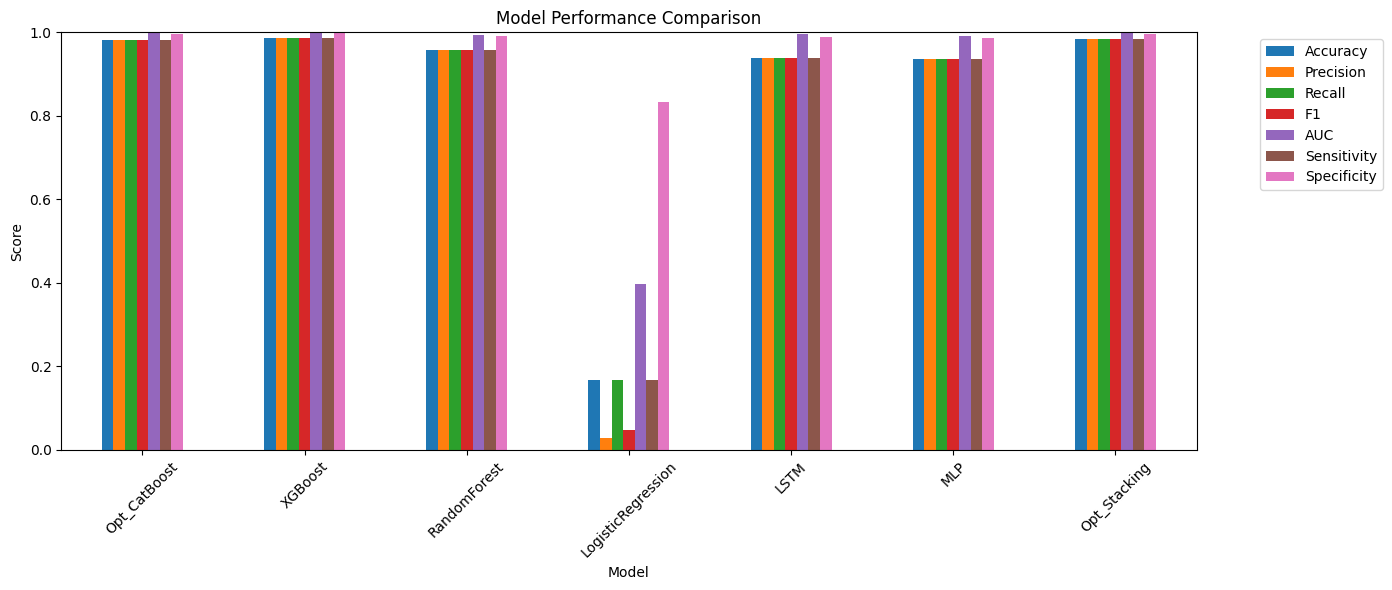

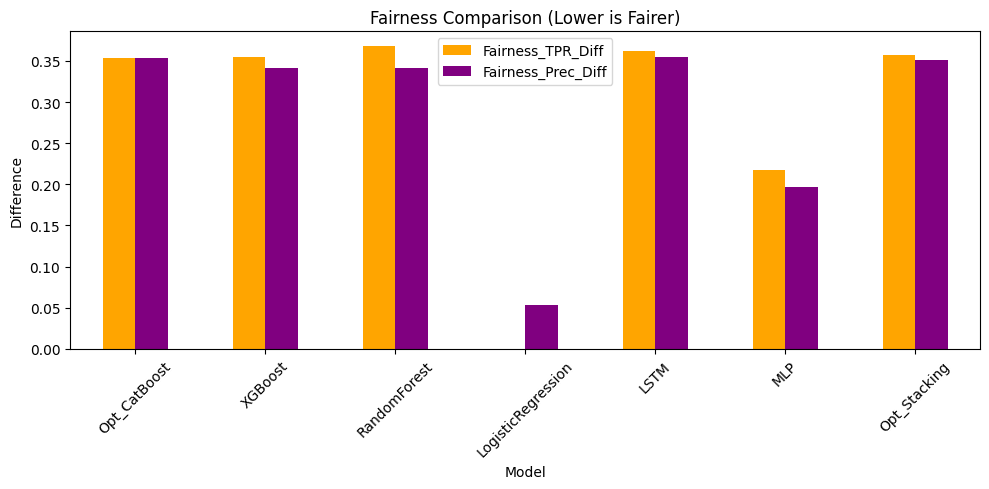

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


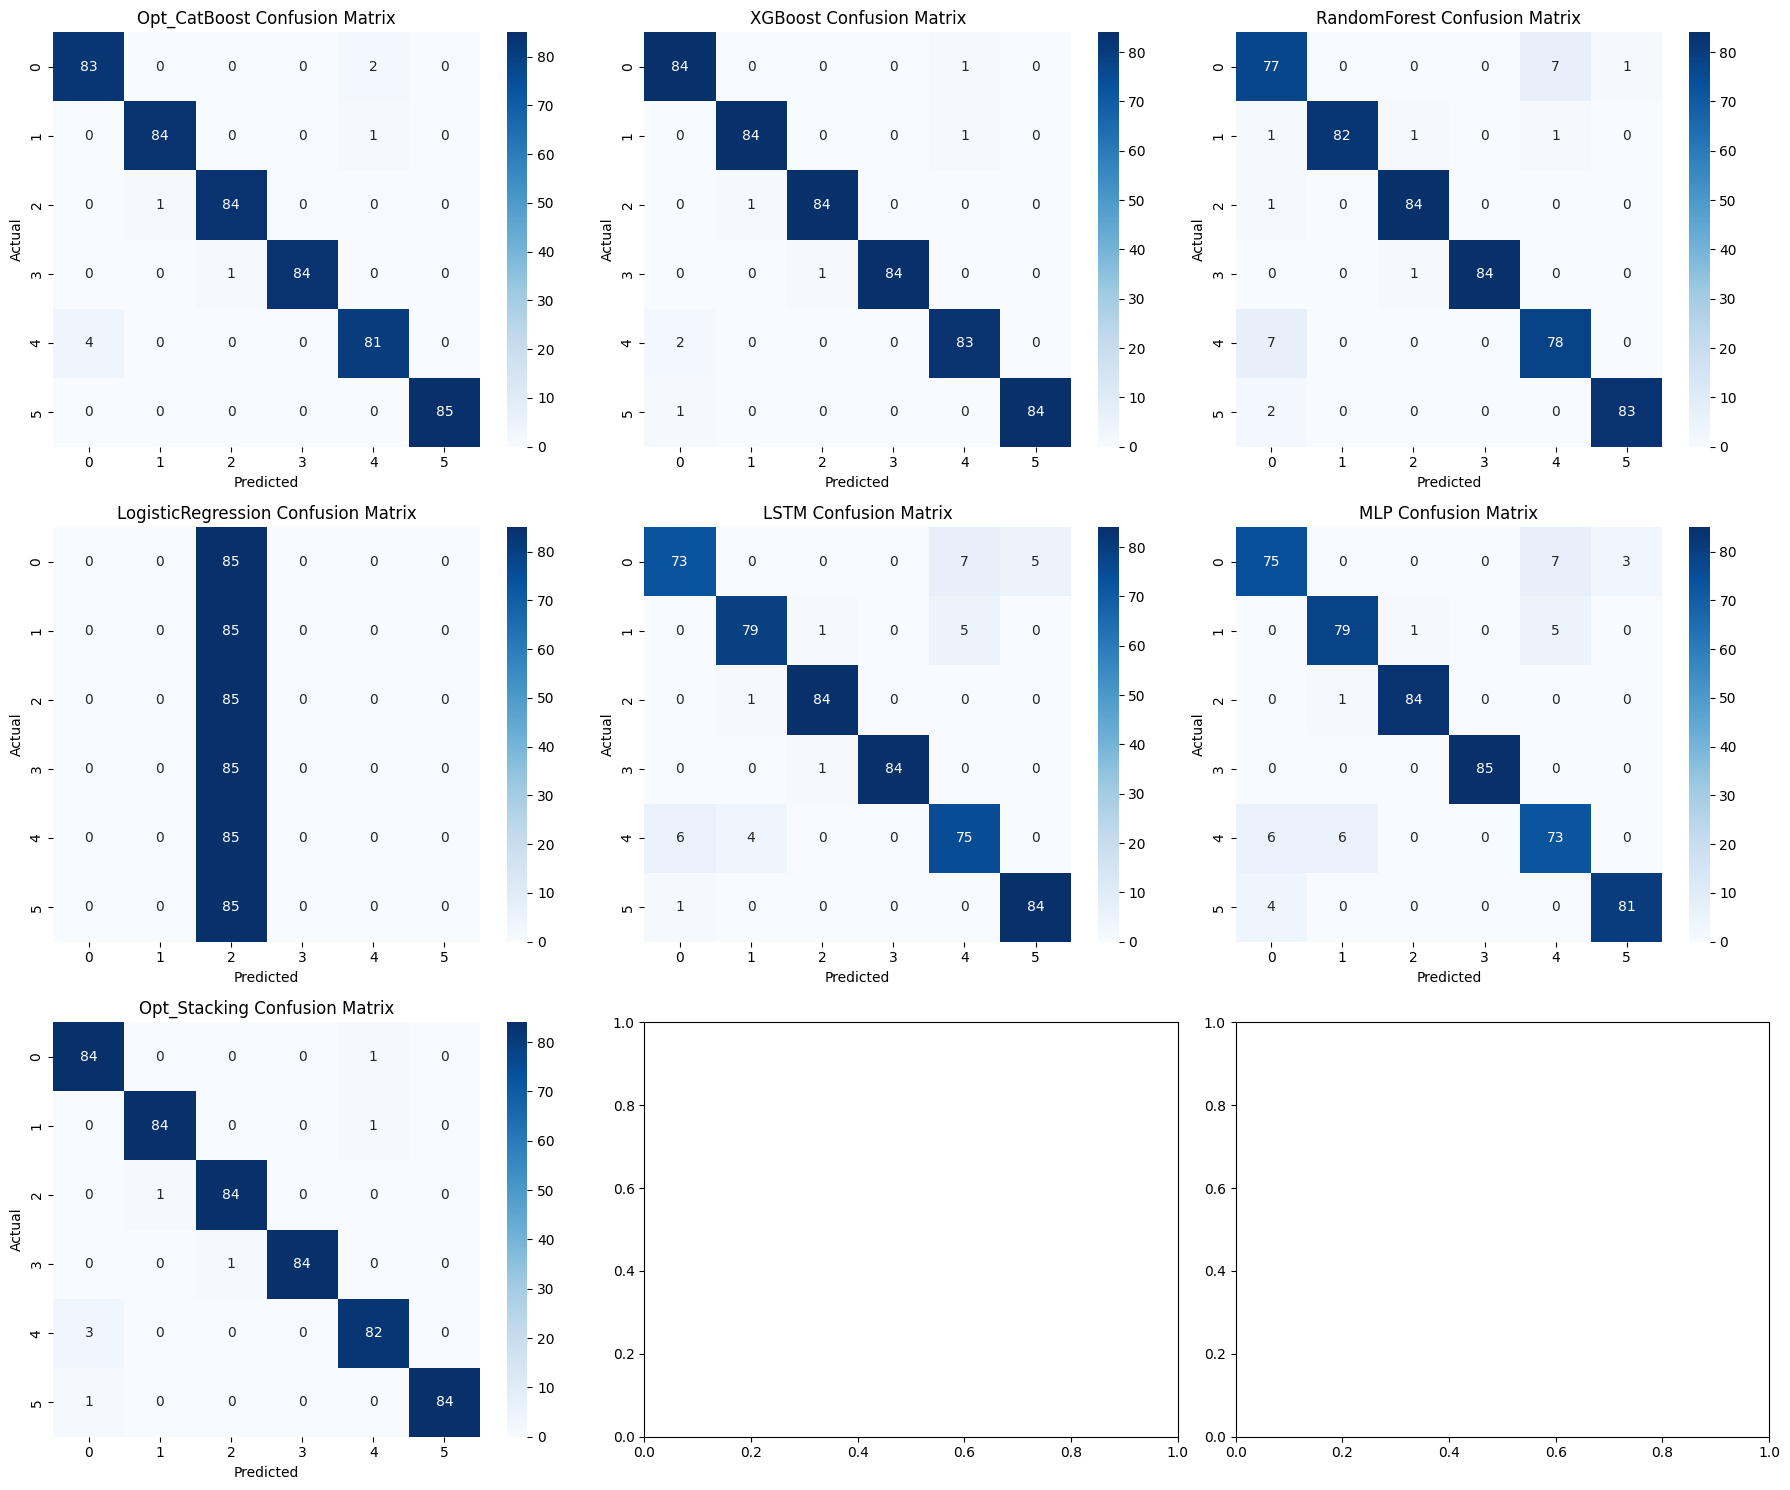


🏆 BEST MODEL SELECTED: XGBoost
Accuracy              0.9863
Precision             0.9864
Recall                0.9863
F1                    0.9863
AUC                   0.9995
Sensitivity           0.9863
Specificity           0.9973
Fairness_TPR_Diff     0.3549
Fairness_Prec_Diff    0.3409
CompositeScore        0.9191
Name: XGBoost, dtype: float64
✅ Model saved as best_model_XGBoost.pkl


In [107]:

models = {

    'Opt_CatBoost': opt_cat_model,
    'XGBoost': XGboost_model,
    'RandomForest': rf_model,
    'LogisticRegression': lr_model,
    'LSTM': opt_lstm_model,
    'MLP': opt_mlp_model,
    'Opt_Stacking': opt_stack_model
}

def evaluate_model(name, model, X_test, y_test):
    result = {'Model': name}

  
    if 'LSTM' in name or 'MLP' in name:
        X_input = X_test.values 
        if 'LSTM' in name:
            X_input = X_input.reshape((X_input.shape[0], 1, X_input.shape[1]))
    else:
        X_input = X_test

 
    y_pred = model.predict(X_input)

    
    if 'LSTM' in name or 'MLP' in name:
        if y_pred.shape[1] > 1:  # multi-class
            y_pred_classes = np.argmax(y_pred, axis=1)
        else:  # binary
            y_pred_classes = (y_pred > 0.5).astype(int).flatten()
        y_pred_probs = y_pred
    else:
        y_pred_classes = y_pred
        try:
            y_pred_probs = model.predict_proba(X_input)
        except:
            y_pred_probs = None

    
    result['Accuracy'] = accuracy_score(y_test, y_pred_classes)
    result['Precision'] = precision_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    result['Recall'] = recall_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    result['F1'] = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)

    # AUC
    try:
        num_classes = len(np.unique(y_test))
        y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
        result['AUC'] = roc_auc_score(y_test_bin, y_pred_probs, average='macro', multi_class='ovr')
    except:
        result['AUC'] = np.nan

    # Sensitivity & Specificity
    cm = confusion_matrix(y_test, y_pred_classes)
    sens_list, spec_list = [], []
    for i in range(len(np.unique(y_test))):
        TP = cm[i,i]
        FN = np.sum(cm[i,:]) - TP
        FP = np.sum(cm[:,i]) - TP
        TN = np.sum(cm) - (TP+FN+FP)
        sens_list.append(TP / (TP+FN) if (TP+FN) > 0 else 0)
        spec_list.append(TN / (TN+FP) if (TN+FP) > 0 else 0)
    result['Sensitivity'] = np.mean(sens_list)
    result['Specificity'] = np.mean(spec_list)

    # Fairness (optional, only if gender columns exist)
    gender_cols = [c for c in X_test.columns if 'gender_' in c]
    if len(gender_cols) == 2 and y_pred_probs is not None:
        gender_onehot = X_test[gender_cols].values
        gender = np.argmax(gender_onehot, axis=1)
        y_pred_idx = np.argmax(y_pred_probs, axis=1)
        groups = np.unique(gender)
        tpr_diff_list, precision_diff_list = [], []
        for c in np.unique(y_test):
            TPRs, Precisions = [], []
            for g in groups:
                idx = np.where(gender==g)
                TP = np.sum((y_pred_idx[idx]==c) & (y_test[idx]==c))
                FN = np.sum((y_pred_idx[idx]!=c) & (y_test[idx]==c))
                FP = np.sum((y_pred_idx[idx]==c) & (y_test[idx]!=c))
                TPRs.append(TP / (TP+FN) if (TP+FN)>0 else 0)
                Precisions.append(TP / (TP+FP) if (TP+FP)>0 else 0)
            tpr_diff_list.append(abs(TPRs[0]-TPRs[1]))
            precision_diff_list.append(abs(Precisions[0]-Precisions[1]))
        result['Fairness_TPR_Diff'] = np.mean(tpr_diff_list)
        result['Fairness_Prec_Diff'] = np.mean(precision_diff_list)
    else:
        result['Fairness_TPR_Diff'] = np.nan
        result['Fairness_Prec_Diff'] = np.nan

    return result


results = []
for name, model in models.items():
    print(f"Evaluating {name} ...")
    res = evaluate_model(name, model, X_test, y_test)
    results.append(res)

results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)


print("\n=== MODEL PERFORMANCE COMPARISON ===")
display(results_df.round(4))

metrics_to_plot = ['Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity']
plt.figure(figsize=(12,6))
results_df[metrics_to_plot].plot(kind='bar', figsize=(14,6), rot=45)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


fairness_metrics = ['Fairness_TPR_Diff','Fairness_Prec_Diff']
results_df[fairness_metrics].plot(kind='bar', figsize=(10,5), color=['orange','purple'])
plt.title("Fairness Comparison (Lower is Fairer)")
plt.ylabel("Difference")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()
for i, (name, model) in enumerate(models.items()):
    if i >= len(axes): break
    # Handle Keras predictions
    if 'LSTM' in name or 'MLP' in name:
        X_input = X_test.values
        if 'LSTM' in name:
            X_input = X_input.reshape((X_input.shape[0], 1, X_input.shape[1]))
        y_pred = model.predict(X_input)
        if y_pred.shape[1] > 1:
            y_pred_classes = np.argmax(y_pred, axis=1)
        else:
            y_pred_classes = (y_pred > 0.5).astype(int).flatten()
    else:
        y_pred_classes = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
plt.tight_layout()
plt.show()


results_df['CompositeScore'] = (
    0.2*results_df['Accuracy'] + 
    0.2*results_df['F1'] +
    0.15*results_df['Recall'] +
    0.15*results_df['Precision'] +
    0.1*results_df['AUC'].fillna(0) +
    0.1*results_df['Sensitivity'] +
    0.1*results_df['Specificity']
) - 0.1*(results_df['Fairness_TPR_Diff'].fillna(0) + results_df['Fairness_Prec_Diff'].fillna(0))

best_model_name = results_df['CompositeScore'].idxmax()
best_model = models[best_model_name]

print(f"\n🏆 BEST MODEL SELECTED: {best_model_name}")
print(results_df.loc[best_model_name].round(4))

joblib.dump(best_model, f'best_model_{best_model_name}.pkl')
print(f"✅ Model saved as best_model_{best_model_name}.pkl")


### 5. Explainable & Interpretable AI

In [108]:


best_model = joblib.load('best_model_XGBoost.pkl')



trees_text = best_model.get_booster().get_dump()
first_tree = trees_text[0].split('\n')


def parse_tree(lines):
    stack = []
    nodes_dict = {}
    for line in lines:
        if not line.strip():
            continue
       
       
        level = line.count('\t')
        content = line.strip()
        node_id = content.split(':')[0]
       
       
        if level == 0:
            node = Node(content)
        else:
            parent = stack[level-1]
            node = Node(content, parent=parent)
        nodes_dict[node_id] = node
       
       
        if len(stack) > level:
            stack[level] = node
        else:
            stack.append(node)
    return nodes_dict[first_tree[0].split(':')[0]]  # root node


root_node = parse_tree(first_tree)

# Print tree structure
for pre, fill, node in RenderTree(root_node):
    print(f"{pre}{node.name}")


DotExporter(root_node).to_dotfile("xgboost_tree.dot")
print("\n✅ Tree exported to xgboost_tree.dot. You can visualize it with Graphviz.")


0:[weight<76.1259613] yes=1,no=2,missing=2
├── 1:[weight<55] yes=3,no=4,missing=4
│   ├── 3:[height<1.64074504] yes=7,no=8,missing=8
│   │   ├── 7:[weight<45.2486267] yes=13,no=14,missing=14
│   │   │   ├── 13:[freq_of_veg_consum<2.0410676] yes=23,no=24,missing=24
│   │   │   │   ├── 23:[weight<42.2374649] yes=37,no=38,missing=38
│   │   │   │   │   ├── 37:leaf=-0.0226027407
│   │   │   │   │   └── 38:leaf=0.107142858
│   │   │   │   └── 24:leaf=-0.0287946444
│   │   │   └── 14:[height<1.63035703] yes=25,no=26,missing=26
│   │   │       ├── 25:leaf=0.134098932
│   │   │       └── 26:leaf=0.0315789469
│   │   └── 8:[weight<54.419796] yes=15,no=16,missing=16
│   │       ├── 15:leaf=-0.0292093698
│   │       └── 16:[height<1.73430932] yes=27,no=28,missing=28
│   │           ├── 27:leaf=0.00789473578
│   │           └── 28:leaf=-0.0226027407
│   └── 4:[num_of_main_meals<3.03779006] yes=9,no=10,missing=10
│       ├── 9:[height<1.61873603] yes=17,no=18,missing=18
│       │   ├── 17:[weight<6

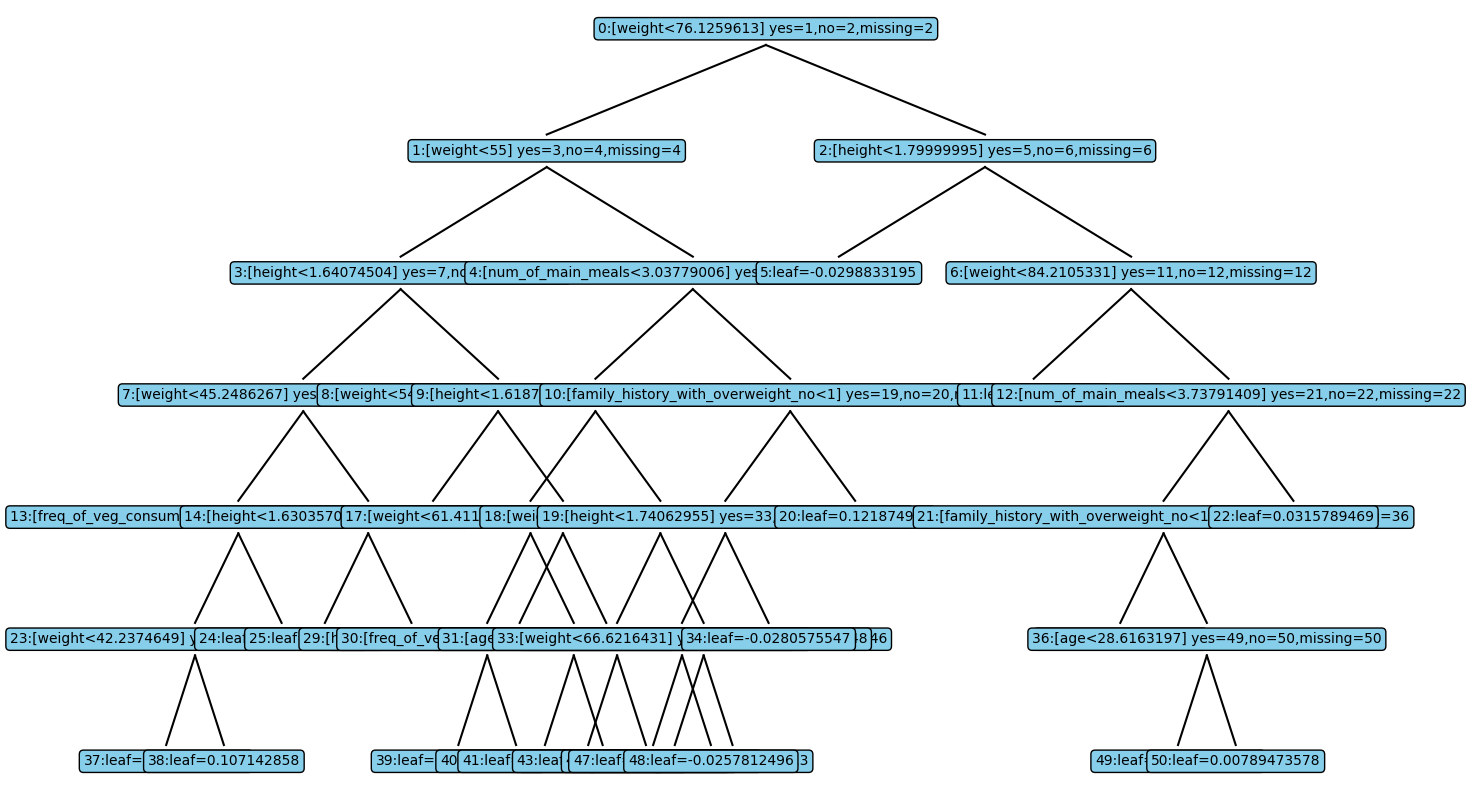

In [113]:


best_model = joblib.load('best_model_XGBoost.pkl')


trees_text = best_model.get_booster().get_dump()
first_tree = trees_text[0].split('\n')


def parse_tree(lines):
    stack = []
    nodes_dict = {}
    for line in lines:
        if not line.strip():
            continue
        level = line.count('\t')
        content = line.strip()
        node_id = content.split(':')[0]
     
     
        if level == 0:
            node = Node(content)
        else:
            parent = stack[level-1]
            node = Node(content, parent=parent)
        nodes_dict[node_id] = node
        if len(stack) > level:
            stack[level] = node
        else:
            stack.append(node)
    return nodes_dict[first_tree[0].split(':')[0]]  # root node



root_node = parse_tree(first_tree)


def plot_tree(node, x=0, y=0, dx=1.0, dy=1.5, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16, 10))
        ax.axis('off')

    
    
    ax.text(x, y, node.name, ha='center', va='center',
            bbox=dict(facecolor='skyblue', edgecolor='black', boxstyle='round,pad=0.3'))

    # Plot children recursively
    children = node.children
    if children:
        spacing = dx / max(len(children), 1)
        start_x = x - dx/2
        for i, child in enumerate(children):
            child_x = start_x + spacing*(i+0.5)
            child_y = y - dy
            # Draw line
            ax.plot([x, child_x], [y-0.2, child_y+0.2], 'k-')
            plot_tree(child, child_x, child_y, dx/1.5, dy, ax)

    return ax

# Plot the tree
ax = plot_tree(root_node)
plt.show()


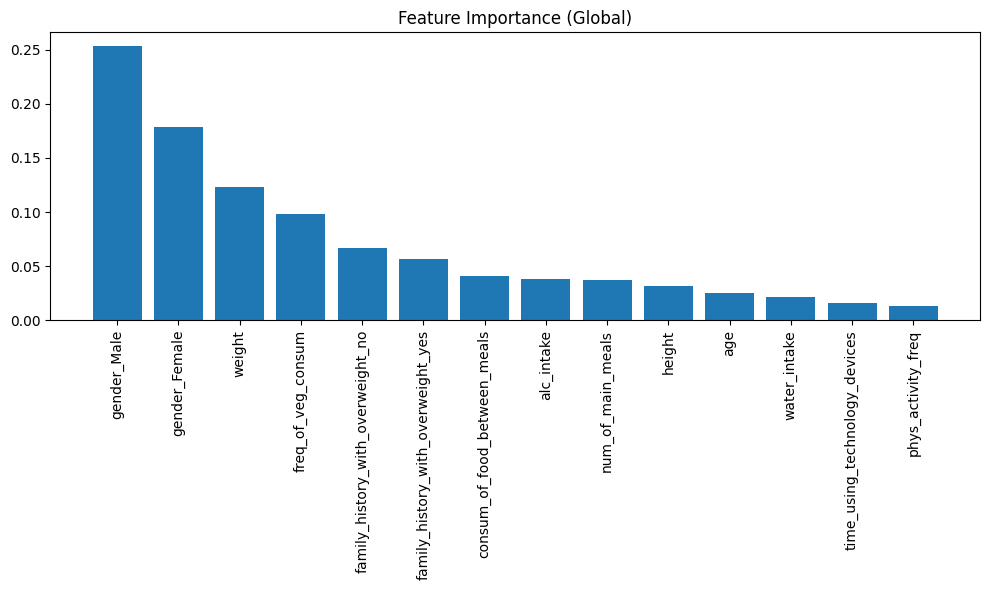

In [109]:

model = joblib.load('best_model_XGBoost.pkl')
X = df.drop(columns=[
    'obesity_level_Normal_Weight',
    'obesity_level_Obesity_Type_I',
    'obesity_level_Obesity_Type_II',
    'obesity_level_Obesity_Type_III',
    'obesity_level_Over_weight',
    'obesity_level_Under_Weight'
])

y_columns = [
    'obesity_level_Normal_Weight',
    'obesity_level_Obesity_Type_I',
    'obesity_level_Obesity_Type_II',
    'obesity_level_Obesity_Type_III',
    'obesity_level_Over_weight',
    'obesity_level_Under_Weight'
]

y = df[y_columns].idxmax(axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance (Global)")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


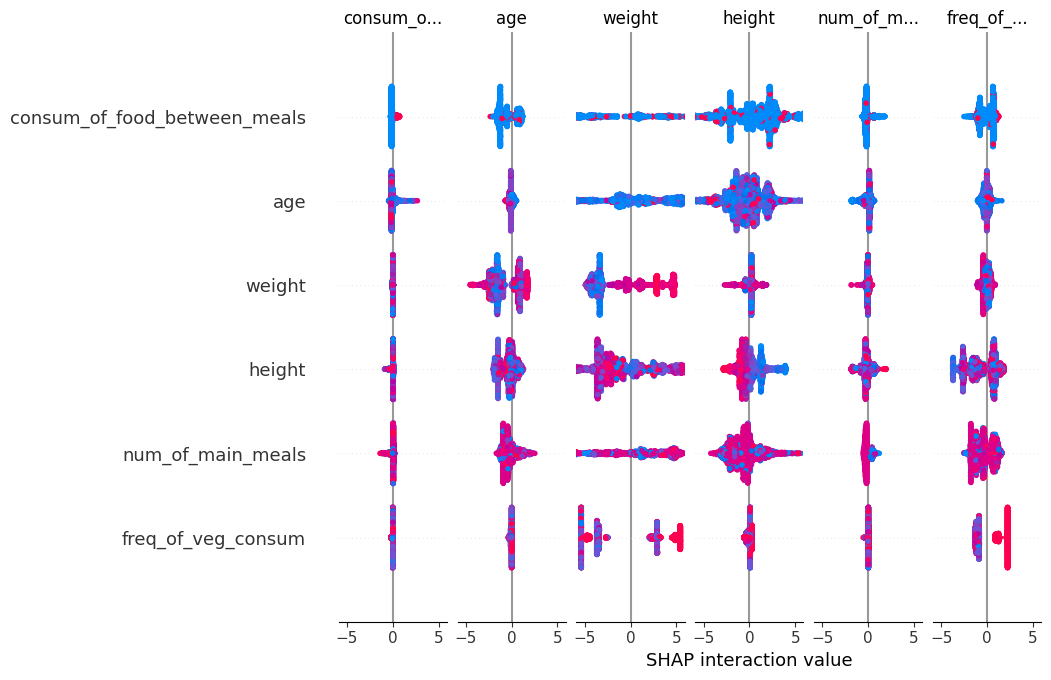

In [110]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)


Explaining prediction for class: 2


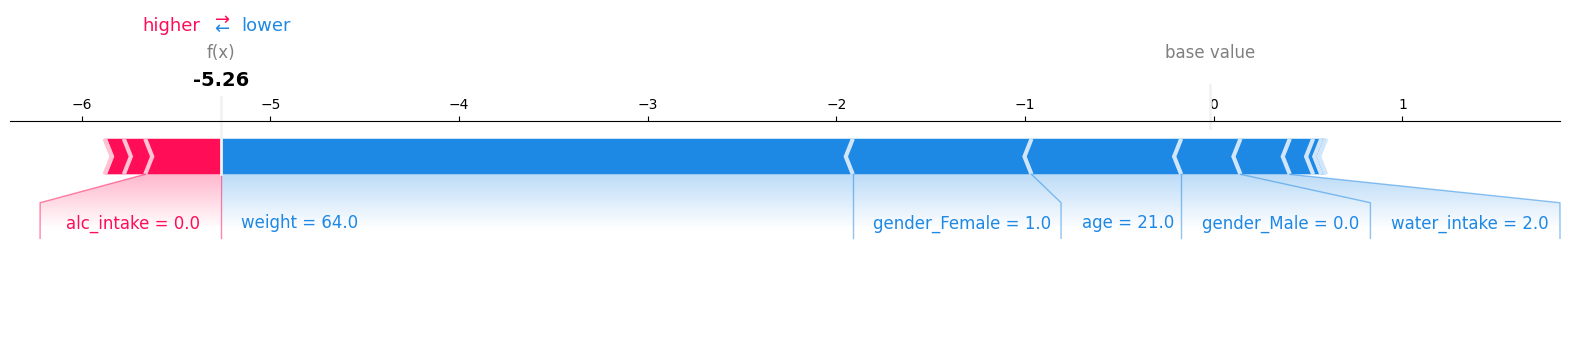

<Figure size 640x480 with 0 Axes>

In [111]:



i = 0 
class_idx = 2 

shap.initjs()


print(f"Explaining prediction for class: {model.classes_[class_idx]}")

#
force_plot = shap.force_plot(
    base_value=explainer.expected_value[class_idx],  
    shap_values=shap_values[i][:, class_idx],         
    features=X.iloc[i],
    feature_names=X.columns,
    matplotlib=True  
)


import matplotlib.pyplot as plt
plt.gcf().set_facecolor("white")

plt.show()


In [112]:

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    mode="classification",
    feature_names=X.columns.tolist(),
    class_names=le.classes_.tolist(),
    discretize_continuous=True
)


idx = 0  
print(f"✅ Explaining prediction for sample #{idx}, true label: {le.classes_[y_test[idx]]}")

exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[idx],
    predict_fn=model.predict_proba,  
    num_features=8                  
)


try:
    html_output = exp.as_html(show_table=True)

   
    styled_output = f"""
    <div style="background-color:white; color:black; padding:10px; border-radius:8px;">
        {html_output}
    </div>
    """

    display(HTML(styled_output))
except Exception as e:
    print(f"⚠️ Could not display in notebook ({e}). Saving to file instead.")
    exp.save_to_file("lime_explanation.html")
    print("✅ LIME explanation saved as lime_explanation.html")


print("\n📋 Feature contributions:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.3f}")


✅ Explaining prediction for sample #0, true label: obesity_level_Obesity_Type_III



📋 Feature contributions:
weight > 111.00: -0.126
2.49 < freq_of_veg_consum <= 3.00: -0.076
22.71 < age <= 26.00: -0.049
0.00 < gender_Female <= 1.00: 0.037
0.00 < alc_intake <= 1.00: 0.028
family_history_with_overweight_no <= 0.00: 0.026
gender_Male <= 0.00: 0.018
water_intake > 2.47: 0.018
